In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
from IPython.display import display
from sklearn.externals import joblib
from collections import Counter

basepath = os.path.expanduser('../')

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Load Data

In [4]:
%%time

app_train   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_train.pkl'))
app_test    = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_test.pkl'))

CPU times: user 48.8 ms, sys: 99.4 ms, total: 148 ms
Wall time: 3.07 s


In [5]:
# additional tables

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau.pkl'))
bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau_balance.pkl'))
prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/previous_application.pkl'))
installments = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/installments_payments.pkl')) 
pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/POS_CASH_balance.pkl'))
credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/credit_card_balance.pkl'))

## Random Customer

In [6]:
SK_ID_CURR = app_train.sample().SK_ID_CURR.values[0]; SK_ID_CURR

117491

### Current Application

In [11]:
display_all(app_train.loc[app_train.SK_ID_CURR == SK_ID_CURR].T)

,110786
AMT_ANNUITY,31995
AMT_CREDIT,755190
AMT_GOODS_PRICE,675000
AMT_INCOME_TOTAL,225000
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_YEAR,3


### Bureau

In [7]:
display_all(bureau.loc[bureau.SK_ID_CURR == SK_ID_CURR].T)

,676019,676020,676021,676022,1338062
SK_ID_CURR,117491,117491,117491,117491,117491
SK_ID_BUREAU,6159295,6159296,6159297,6159298,6159294
CREDIT_ACTIVE,Closed,Closed,Closed,Active,Closed
CREDIT_CURRENCY,currency 1,currency 1,currency 1,currency 1,currency 1
DAYS_CREDIT,-960,-803,-882,-1402,-1724
CREDIT_DAY_OVERDUE,0,0,0,0,0
DAYS_CREDIT_ENDDATE,-838,-712,-699,31040,-1416
DAYS_ENDDATE_FACT,-814,-700,-685,NaN,-1416
AMT_CREDIT_MAX_OVERDUE,NaN,NaN,NaN,NaN,NaN
CNT_CREDIT_PROLONG,0,0,0,0,0


### Bureau Balance

In [8]:
display_all(bureau.loc[bureau.SK_ID_CURR == SK_ID_CURR, ['SK_ID_BUREAU']]\
                  .merge(bureau_bal, on=['SK_ID_BUREAU'], how='left'))

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,6159295,NaN,NaN
1,6159296,NaN,NaN
2,6159297,NaN,NaN
3,6159298,NaN,NaN
4,6159294,NaN,NaN


### Previous Application

In [9]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, :].T)

,83693,133896,194299,389221,777278,1088119,1300865
SK_ID_PREV,1804158,2502461,1204864,1622096,1142578,2265476,2075947
SK_ID_CURR,117491,117491,117491,117491,117491,117491,117491
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Consumer loans,Cash loans,Cash loans,Consumer loans
AMT_ANNUITY,NaN,NaN,45000,13067.1,NaN,NaN,40050.9
AMT_APPLICATION,0,0,0,106636,0,0,230751
AMT_CREDIT,0,0,900000,117194,0,0,216585
AMT_DOWN_PAYMENT,NaN,NaN,NaN,0,NaN,NaN,23076
AMT_GOODS_PRICE,NaN,NaN,NaN,106636,NaN,NaN,230751
WEEKDAY_APPR_PROCESS_START,FRIDAY,SATURDAY,WEDNESDAY,WEDNESDAY,WEDNESDAY,MONDAY,THURSDAY
HOUR_APPR_PROCESS_START,13,11,16,16,10,14,14


### POS Cash

In [10]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, ['SK_ID_CURR', 'SK_ID_PREV']]\
                    .merge(pos_cash.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], 
                                                ascending=[True, True, False]), 
                           on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')) 

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,117491,1804158,NaN,NaN,NaN,NaN,NaN,NaN
1,117491,2502461,NaN,NaN,NaN,NaN,NaN,NaN
2,117491,1204864,NaN,NaN,NaN,NaN,NaN,NaN
3,117491,1622096,-46.0,11.0,0.0,Completed,0.0,0.0
4,117491,1622096,-47.0,12.0,1.0,Active,0.0,0.0
5,117491,1622096,-48.0,12.0,2.0,Active,0.0,0.0
6,117491,1622096,-49.0,12.0,3.0,Active,0.0,0.0
7,117491,1622096,-50.0,11.0,4.0,Active,0.0,0.0
8,117491,1622096,-51.0,11.0,5.0,Active,0.0,0.0
9,117491,1622096,-52.0,11.0,6.0,Active,0.0,0.0


### Credit Balance

In [11]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, ['SK_ID_CURR', 'SK_ID_PREV']]\
                    .merge(credit_bal.sort_values(by=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], 
                                                  ascending=[True, True, False]), 
                           on=['SK_ID_CURR', 'SK_ID_PREV'], how='left').T) 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
SK_ID_CURR,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491,117491
SK_ID_PREV,1804158,2502461,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1204864,1622096,1142578,2265476,2075947
MONTHS_BALANCE,NaN,NaN,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-20,-21,-22,-23,NaN,NaN,NaN,NaN
AMT_BALANCE,NaN,NaN,350736,197187,203140,235741,241309,246530,251569,256657,261380,266156,270570,276381,266998,286238,291145,285466,290399,293659,230197,222447,239593,231661,172166,NaN,NaN,NaN,NaN
AMT_CREDIT_LIMIT_ACTUAL,NaN,NaN,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,900000,NaN,NaN,NaN,NaN
AMT_DRAWINGS_ATM_CURRENT,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9000,0,0,0,0,0,0,58500,166500,NaN,NaN,NaN,NaN
AMT_DRAWINGS_CURRENT,NaN,NaN,132498,0,0,0,0,0,0,0,0,0,0,0,0,0,9000,0,0,66838.5,0,0,0,58500,166500,NaN,NaN,NaN,NaN
AMT_DRAWINGS_OTHER_CURRENT,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
AMT_DRAWINGS_POS_CURRENT,NaN,NaN,132498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66838.5,0,0,0,0,0,NaN,NaN,NaN,NaN
AMT_INST_MIN_REGULARITY,NaN,NaN,11070.3,11356.4,11639.9,11905.5,12162.9,12421.3,12662.5,12905.7,13130.9,13380.3,13635.7,13883.3,14133.1,14364.7,14095,14327.8,14532.8,11366.1,11552.3,11832.2,12033.9,0,0,NaN,NaN,NaN,NaN


### Installments

In [12]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR, ['SK_ID_CURR', 'SK_ID_PREV']]\
                    .merge(installments.sort_values(by=['SK_ID_CURR',
                                                        'SK_ID_PREV',
                                                        'NUM_INSTALMENT_NUMBER']), 
                           on=['SK_ID_CURR', 'SK_ID_PREV'], how='left')) 

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,117491,1804158,NaN,NaN,NaN,NaN,NaN,NaN
1,117491,2502461,NaN,NaN,NaN,NaN,NaN,NaN
2,117491,1204864,0.0,1.0,-651.0,-660.0,12033.855469,12033.855469
3,117491,1204864,0.0,2.0,-660.0,-660.0,116.144997,116.144997
4,117491,1204864,0.0,3.0,-620.0,-621.0,11832.209961,11832.209961
5,117491,1204864,0.0,4.0,-621.0,-621.0,1667.790039,1667.790039
6,117491,1204864,0.0,5.0,-590.0,-595.0,11552.264648,11552.264648
7,117491,1204864,0.0,6.0,-595.0,-595.0,147.735001,147.735001
8,117491,1204864,0.0,7.0,-559.0,-562.0,11366.099609,11366.099609
9,117491,1204864,0.0,8.0,-562.0,-562.0,333.899994,333.899994


### When did the client opt for first credit with Home Credit ?

In [15]:
join_date = prev_app.loc[(prev_app.NAME_CLIENT_TYPE == 'New') &\
            (prev_app.NAME_CONTRACT_STATUS == 'Approved')].groupby('SK_ID_CURR')['DAYS_DECISION'].max()
join_date = -join_date/365

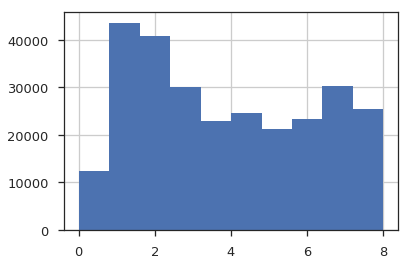

In [17]:
join_date.hist();

In [18]:
join_date = app_train.SK_ID_CURR.map(join_date)
join_date[join_date.isnull()].shape[0] / len(join_date)

0.22936740474324496

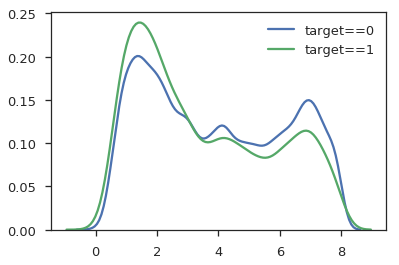

In [21]:
sns.kdeplot(join_date[app_train.TARGET == 0], label='target==0')
sns.kdeplot(join_date[app_train.TARGET == 1], label='target==1');

### Difference between date when a person opted for credit from Home Credit and Employment Date

In [26]:
join_date = prev_app.loc[(prev_app.NAME_CLIENT_TYPE == 'New') &\
            (prev_app.NAME_CONTRACT_STATUS == 'Approved')].groupby('SK_ID_CURR')['DAYS_DECISION'].max()
join_date = -join_date/365
join_date = app_train.SK_ID_CURR.map(join_date)

diff_join_employed_date = (-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365) - join_date

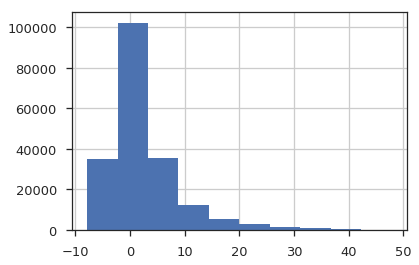

In [29]:
diff_join_employed_date.hist();

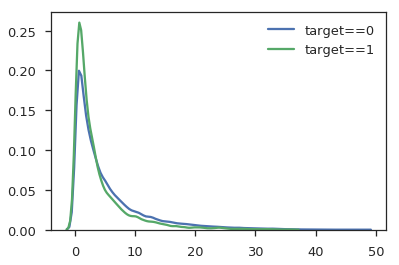

In [36]:
sns.kdeplot(diff_join_employed_date[(diff_join_employed_date > 0) & (app_train.TARGET == 0)], label='target==0')
sns.kdeplot(diff_join_employed_date[(diff_join_employed_date > 0) & (app_train.TARGET == 1)], label='target==1');

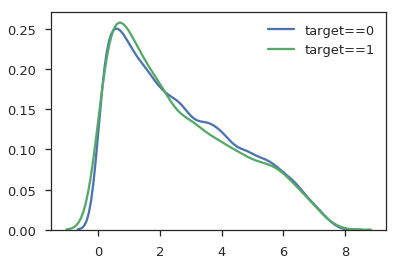

In [37]:
sns.kdeplot((-diff_join_employed_date[(diff_join_employed_date < 0) & (app_train.TARGET == 0)]), label='target==0')
sns.kdeplot((-diff_join_employed_date[(diff_join_employed_date < 0) & (app_train.TARGET == 1)]), label='target==1');

### Relationship between Income and Employment (in Years)

In [41]:
income_emp = (app_train.AMT_INCOME_TOTAL / (-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365))\
             .replace([np.inf, -np.inf], np.nan)

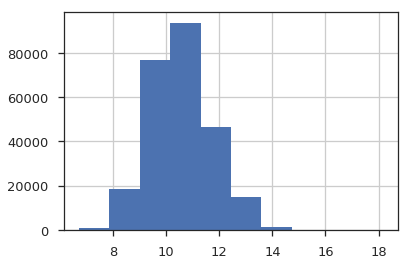

In [44]:
income_emp.map(np.log1p).hist();

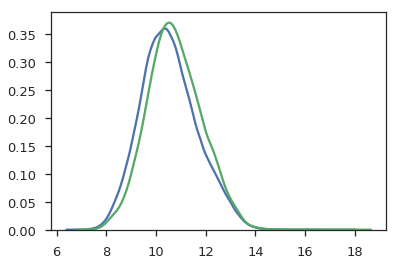

In [45]:
sns.kdeplot(income_emp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(income_emp[app_train.TARGET == 1].map(np.log1p));

### Represent contract status of previous applications as string of characters

In [102]:
%%time

contract_status_str = prev_app.sort_values(by='DAYS_DECISION', ascending=False).groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS']\
                      .apply(lambda x: ''.join([z[0:1] for z in x]))

CPU times: user 1min 21s, sys: 1.87 s, total: 1min 22s
Wall time: 1min 22s


In [103]:
contract_status_str = app_train.SK_ID_CURR.map(contract_status_str)
contract_status_str[contract_status_str.isnull()].shape[0] / len(contract_status_str)

0.05350702901684818

In [104]:
ss = pd.crosstab(contract_status_str, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss.sort_values(by=1, ascending=False))

TARGET                0.0   1.0     ratio
SK_ID_CURR                               
A                   47625  4357  0.083817
AA                  30173  2320  0.071400
AAA                 18340  1194  0.061124
AAAA                10159   567  0.052862
RA                   3615   542  0.130382
CAA                  5554   464  0.077102
CA                   5491   437  0.073718
AAAAA                5470   296  0.051335
ARA                  2663   274  0.093292
CAAA                 3955   260  0.061684
RRA                  1286   222  0.147215
RAA                  1663   204  0.109266
ACA                  1864   173  0.084929
CAAAA                2469   154  0.058711
AAAAAA               2767   150  0.051423
AARA                 1486   134  0.082716
UA                   1180   126  0.096478
CCAA                 1575   124  0.072984
CCA                  1262   114  0.082849
ACAA                 1472   107  0.067764
AR                   1009   107  0.095878
ARAA                 1081   102  0

### Relationship of external scores with months balance from bureau

In [5]:
data_recency = bureau_bal.groupby('SK_ID_BUREAU', as_index=False)['MONTHS_BALANCE'].max()
data_recency = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']].merge(data_recency, how='left')
data_recency.head()

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE
0,215354,5714462,NaN
1,215354,5714463,NaN
2,215354,5714464,NaN
3,215354,5714465,NaN
4,215354,5714466,NaN


In [6]:
data_recency = data_recency.groupby('SK_ID_CURR', as_index=False)['MONTHS_BALANCE'].max()
data_recency = app_train.loc[:, ['SK_ID_CURR',
                                 'EXT_SOURCE_1',
                                 'EXT_SOURCE_2',
                                 'EXT_SOURCE_3'
                                ]].merge(data_recency, how='left')

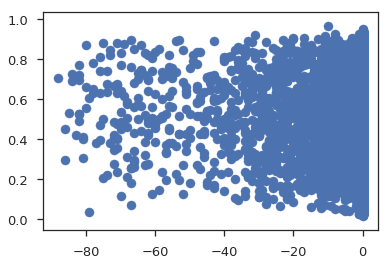

In [11]:
plt.scatter(data_recency.MONTHS_BALANCE, data_recency.EXT_SOURCE_1);

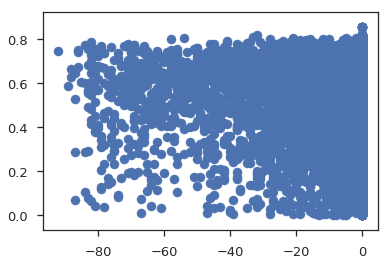

In [12]:
plt.scatter(data_recency.MONTHS_BALANCE, data_recency.EXT_SOURCE_2);

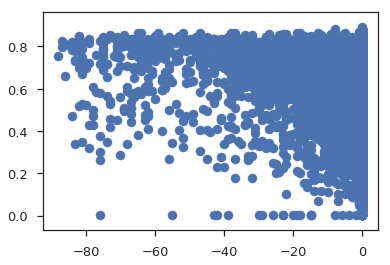

In [13]:
plt.scatter(data_recency.MONTHS_BALANCE, data_recency.EXT_SOURCE_3);

### Hypothesis: Max Annuity of the approved previous credit and current annuity

In [55]:
max_annuity_prev_app = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'AMT_ANNUITY']]\
                               .groupby('SK_ID_CURR')['AMT_ANNUITY'].max()

max_annuity_prev_app = app_train.SK_ID_CURR.map(max_annuity_prev_app)
max_annuity_prev_app[max_annuity_prev_app.isnull()].shape[0] / len(max_annuity_prev_app)

0.056739433711314395

In [56]:
diff_curr_annuity_max_annuity_prev_app = app_train.AMT_ANNUITY - max_annuity_prev_app

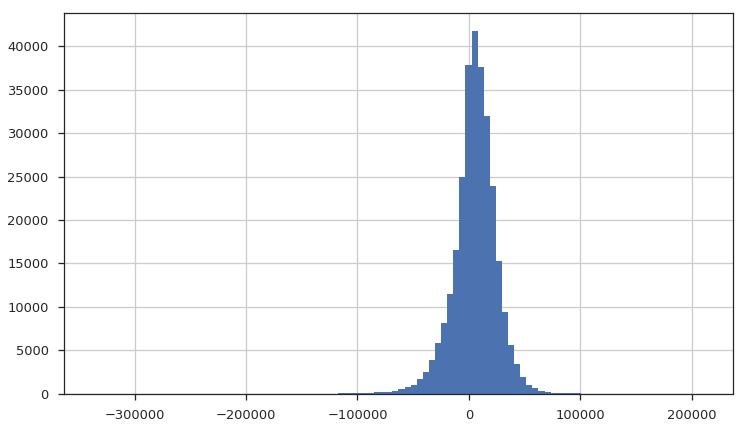

In [58]:
plt.figure(figsize=(12, 7))
diff_curr_annuity_max_annuity_prev_app.hist(bins=100);

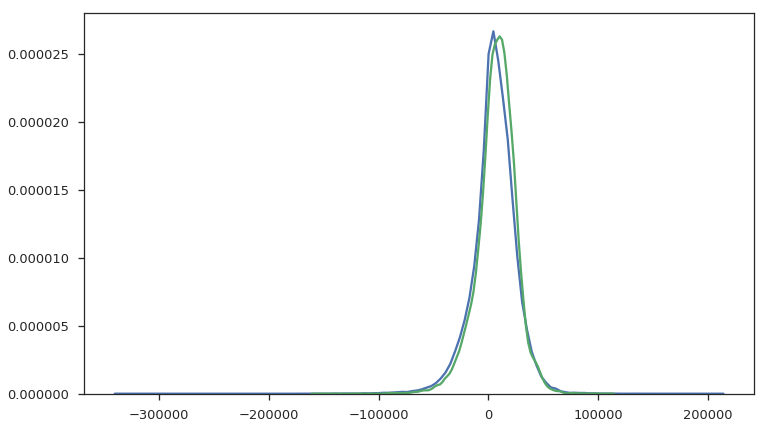

In [59]:
plt.figure(figsize=(12, 7))
sns.kdeplot(diff_curr_annuity_max_annuity_prev_app[app_train.TARGET == 0])
sns.kdeplot(diff_curr_annuity_max_annuity_prev_app[app_train.TARGET == 1]);

In [69]:
ratio_curr_annuity_max_annuity_prev_app = (app_train.AMT_ANNUITY / max_annuity_prev_app).replace([-np.inf, np.inf], np.nan)

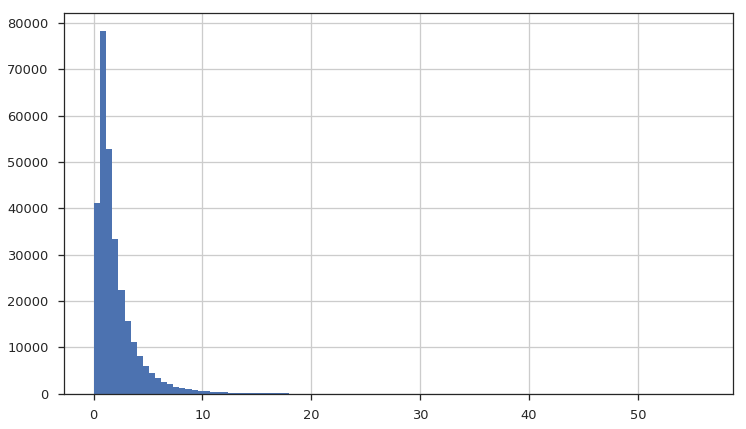

In [70]:
plt.figure(figsize=(12, 7))
ratio_curr_annuity_max_annuity_prev_app.hist(bins=100);

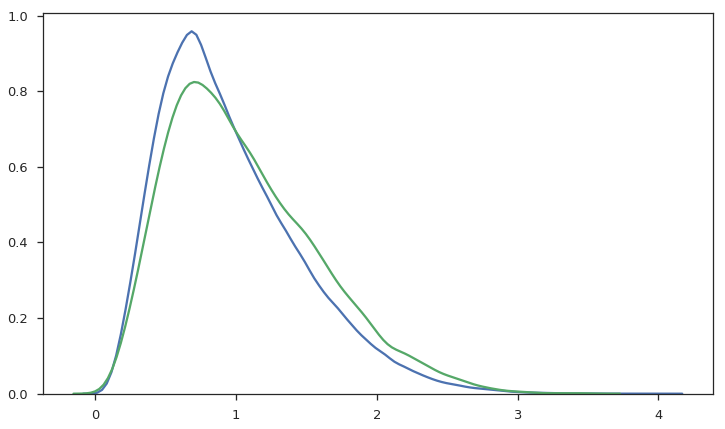

In [72]:
plt.figure(figsize=(12, 7))
sns.kdeplot(ratio_curr_annuity_max_annuity_prev_app[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(ratio_curr_annuity_max_annuity_prev_app[app_train.TARGET == 1].map(np.log1p));

### Relationship between debt, credit and credit enddate

In [39]:
mask = (bureau.CREDIT_ACTIVE == 'Active') & (bureau.AMT_CREDIT_SUM_DEBT > 0) & (bureau.DAYS_CREDIT_ENDDATE > 0)
ratio_debt_credit = bureau.loc[mask, 'AMT_CREDIT_SUM'] - bureau.loc[mask, 'AMT_CREDIT_SUM_DEBT']
ratio_debt_credit_by_enddate = (ratio_debt_credit / bureau.loc[mask, 'DAYS_CREDIT_ENDDATE']).replace([-np.inf, np.inf], np.nan)
tmp = ratio_debt_credit_by_enddate.groupby(bureau.loc[mask, 'SK_ID_CURR']).mean()
tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.4489823128278338

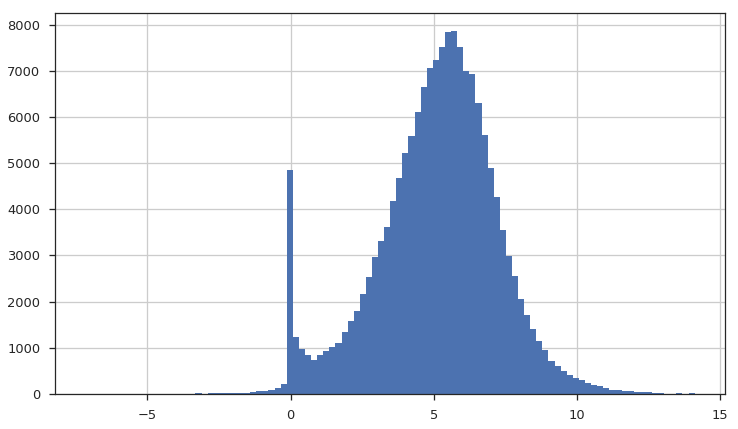

In [36]:
plt.figure(figsize=(12, 7))
tmp.map(np.log1p).hist(bins=100);

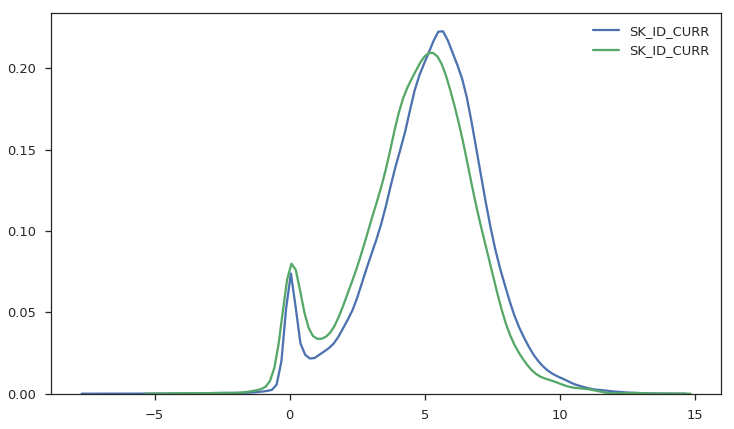

In [37]:
plt.figure(figsize=(12, 7))
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

### Relationship between debt, credit and credit enddate and age, employed since.

In [40]:
mask = (bureau.CREDIT_ACTIVE == 'Active') & (bureau.AMT_CREDIT_SUM_DEBT > 0) & (bureau.DAYS_CREDIT_ENDDATE > 0)
ratio_debt_credit = bureau.loc[mask, 'AMT_CREDIT_SUM'] - bureau.loc[mask, 'AMT_CREDIT_SUM_DEBT']
ratio_debt_credit_by_enddate = (ratio_debt_credit / bureau.loc[mask, 'DAYS_CREDIT_ENDDATE']).replace([-np.inf, np.inf], np.nan)
tmp = ratio_debt_credit_by_enddate.groupby(bureau.loc[mask, 'SK_ID_CURR']).sum()
tmp = app_train.SK_ID_CURR.map(tmp) * ((-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365) / (-app_train.DAYS_BIRTH / 365))

tmp[tmp.isnull()].shape[0] / len(tmp)

0.5431415461560725

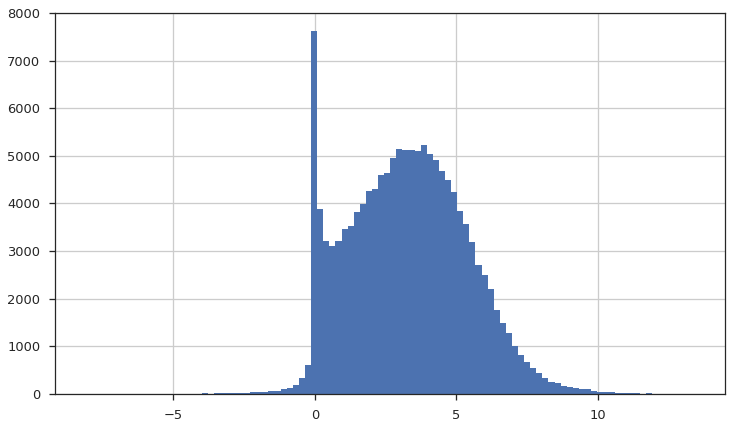

In [41]:
plt.figure(figsize=(12, 7))
tmp.map(np.log1p).hist(bins=100);

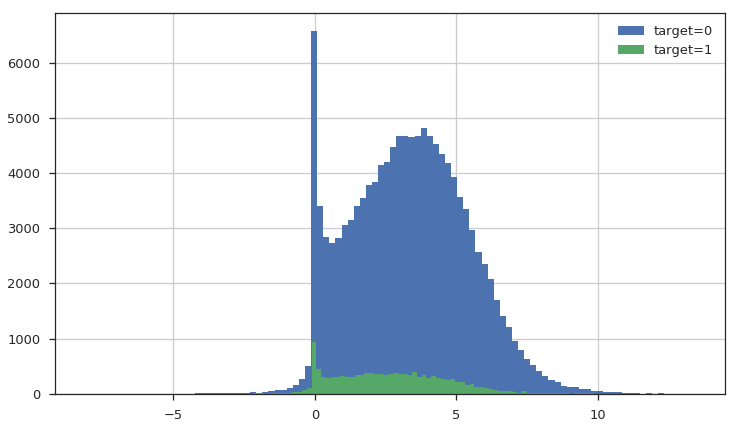

In [42]:
plt.figure(figsize=(12, 7))
tmp[app_train.TARGET == 0].map(np.log1p).hist(bins=100, label='target=0')
tmp[app_train.TARGET == 1].map(np.log1p).hist(bins=100, label='target=1')
plt.legend(loc='best');

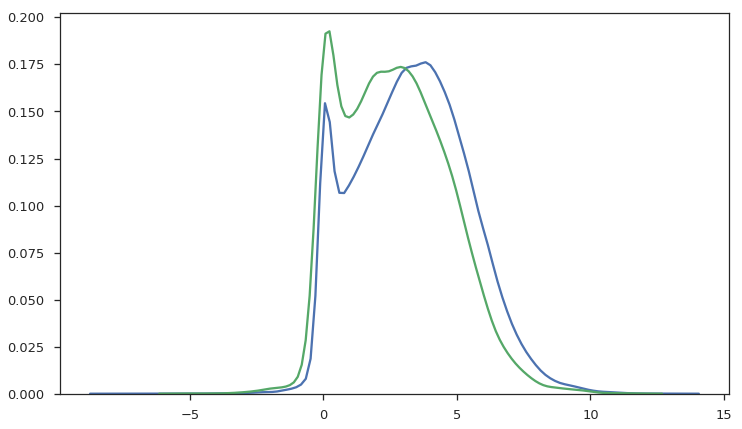

In [43]:
plt.figure(figsize=(12, 7))
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

### Relationship between credit and lenght of pos_cash

In [74]:
mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & (prev_app.NAME_CONTRACT_TYPE != 'Revolving loans')
credit_term = pos_cash.groupby(['SK_ID_CURR', 'SK_ID_PREV']).size().reset_index().rename(columns={0: 'term'})
tmp = prev_app.loc[mask, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT']].merge(credit_term, how='inner')
tmp.loc[:, 'ratio_credit_term'] = tmp.AMT_CREDIT / tmp.term
tmp = tmp.groupby('SK_ID_CURR')['ratio_credit_term'].std()
tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.3673429568373164

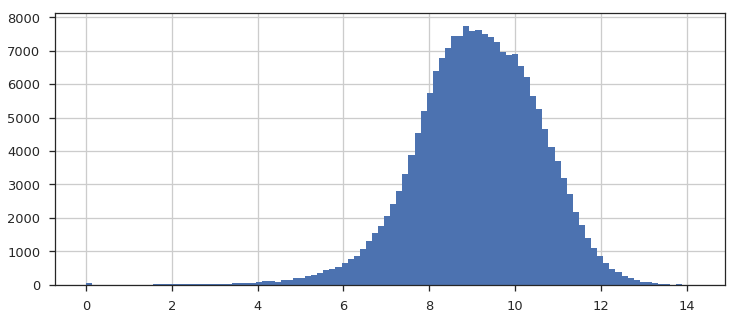

In [75]:
plt.figure(figsize=(12, 5))
tmp.map(np.log1p).hist(bins=100);

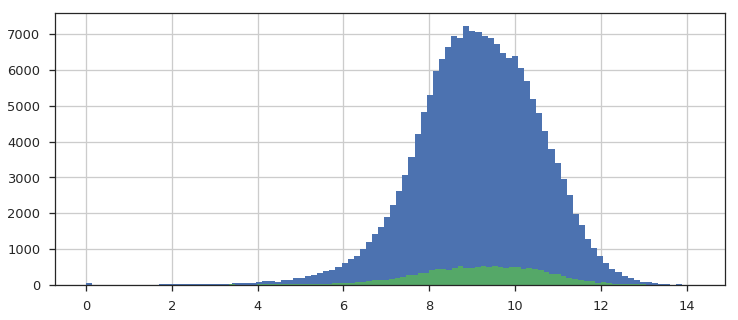

In [76]:
plt.figure(figsize=(12, 5))
tmp[app_train.TARGET == 0].map(np.log1p).hist(bins=100)
tmp[app_train.TARGET == 1].map(np.log1p).hist(bins=100);

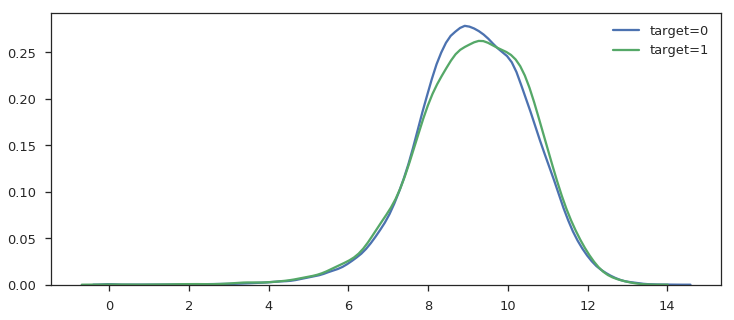

In [77]:
plt.figure(figsize=(12, 5))
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p), label='target=0')
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p), label='target=1');

### Relationship between loan start date from bureau and previous home credit applications and employment start date

In [100]:
mask   = bureau.CREDIT_ACTIVE == 'Active'
bureau_credit_start = bureau.loc[mask, ['SK_ID_CURR', 'DAYS_CREDIT']]

mask = prev_app.NAME_CONTRACT_STATUS == 'Approved'
prev_app_start = prev_app.loc[mask, ['SK_ID_CURR', 'DAYS_DECISION']]

In [120]:
client_employ_bureau_loan_dates = app_train.loc[:, ['SK_ID_CURR', 'DAYS_EMPLOYED', 'TARGET']]\
                                           .merge(bureau_credit_start, how='left')
client_employ_bureau_loan_dates['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

client_employ_hc_loan_dates = app_train.loc[:, ['SK_ID_CURR', 'DAYS_EMPLOYED', 'TARGET']]\
                                           .merge(prev_app_start, how='left')

In [117]:
client_employ_bureau_loan_dates.loc[:, 'loan_before_employment'] = (client_employ_bureau_loan_dates.DAYS_CREDIT > client_employ_bureau_loan_dates.DAYS_EMPLOYED).astype(np.uint8)
client_employ_hc_loan_dates.loc[:, 'loan_before_employment'] = (client_employ_hc_loan_dates.DAYS_DECISION > client_employ_hc_loan_dates.DAYS_EMPLOYED).astype(np.uint8)

btmp = client_employ_bureau_loan_dates.groupby('SK_ID_CURR')['loan_before_employment'].sum()
htmp = client_employ_hc_loan_dates.groupby('SK_ID_CURR')['loan_before_employment'].sum()
tmp  = btmp + htmp

tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.0

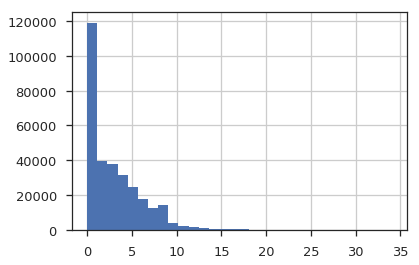

In [118]:
tmp.hist(bins=30);

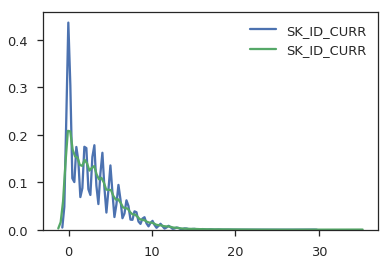

In [119]:
sns.kdeplot(tmp[app_train.TARGET == 0])
sns.kdeplot(tmp[app_train.TARGET == 1]);

In [136]:
client_employ_bureau_loan_dates = app_train.loc[:, ['SK_ID_CURR', 'DAYS_EMPLOYED', 'TARGET']]\
                                           .merge(bureau_credit_start, how='left')
client_employ_bureau_loan_dates['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

client_employ_hc_loan_dates = app_train.loc[:, ['SK_ID_CURR', 'DAYS_EMPLOYED', 'TARGET']]\
                                           .merge(prev_app_start, how='left')

client_employ_bureau_loan_dates.loc[:, 'diff_loan_before_employment'] = (client_employ_bureau_loan_dates.DAYS_CREDIT - client_employ_bureau_loan_dates.DAYS_EMPLOYED)
client_employ_hc_loan_dates.loc[:, 'diff_loan_before_employment'] = (client_employ_hc_loan_dates.DAYS_DECISION - client_employ_hc_loan_dates.DAYS_EMPLOYED)

btmp = client_employ_bureau_loan_dates.groupby('SK_ID_CURR')['diff_loan_before_employment'].sum()
htmp = client_employ_hc_loan_dates.groupby('SK_ID_CURR')['diff_loan_before_employment'].sum()
tmp  = btmp + htmp

tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.0

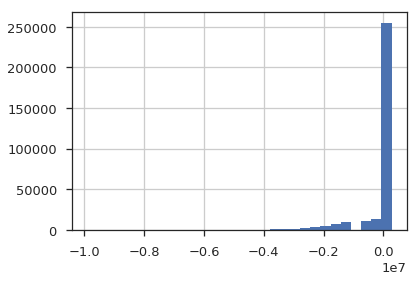

In [137]:
tmp.hist(bins=30);

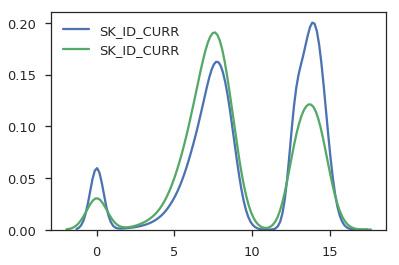

In [138]:
sns.kdeplot((-tmp[app_train.TARGET == 0]).map(np.log1p))
sns.kdeplot((-tmp[app_train.TARGET == 1]).map(np.log1p));

### How many bureau credits were closed prematurely ?

In [19]:
mask = bureau.CREDIT_ACTIVE == 'Closed'
closed_before_scheduled = (bureau.loc[mask, 'DAYS_CREDIT_ENDDATE'] > bureau.loc[mask, 'DAYS_ENDDATE_FACT']).astype(np.uint8)
tmp = closed_before_scheduled.groupby(bureau.loc[mask, 'SK_ID_CURR']).sum()
tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.25152270975672414

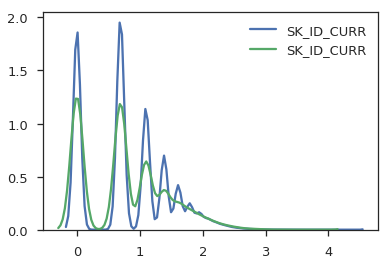

In [22]:
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

In [29]:
mask = bureau.CREDIT_ACTIVE == 'Closed'
diff_closed_before_scheduled = (bureau.loc[mask, 'DAYS_CREDIT_ENDDATE'] - bureau.loc[mask, 'DAYS_ENDDATE_FACT'])
tmp = diff_closed_before_scheduled.groupby(bureau.loc[mask, 'SK_ID_CURR']).mean()
tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.25653066069181263

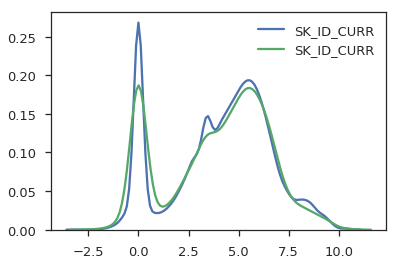

In [30]:
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

### Total debt

In [100]:
mask = (bureau.CREDIT_ACTIVE == 'Active')
total_bureau_debt = bureau.loc[mask, :].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()

mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & (prev_app.DAYS_TERMINATION > 0) & (prev_app.CNT_PAYMENT > 0) &\
       (-prev_app.DAYS_DECISION / 30 < prev_app.CNT_PAYMENT)

remaining_months = prev_app.loc[mask].CNT_PAYMENT - (-prev_app.loc[mask].DAYS_DECISION / 30)
prev_app_debt = prev_app.loc[mask].AMT_ANNUITY * remaining_months

total_debt = total_bureau_debt.add(prev_app_debt, fill_value=0)
total_debt = (app_train.SK_ID_CURR.map(total_debt))

total_debt[total_debt.isnull()].shape[0] / len(total_debt)

0.26918711850958177

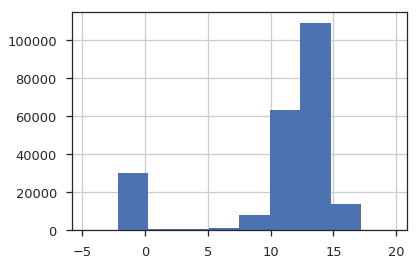

In [101]:
total_debt.map(np.log1p).hist();

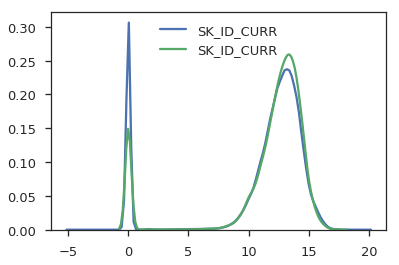

In [102]:
sns.kdeplot(total_debt[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(total_debt[app_train.TARGET == 1].map(np.log1p));

In [79]:
mask = (bureau.CREDIT_ACTIVE == 'Active')
total_bureau_credit = bureau.loc[mask, :].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & (prev_app.DAYS_TERMINATION > 0) & (prev_app.CNT_PAYMENT > 0) &\
       (-prev_app.DAYS_DECISION / 30 < prev_app.CNT_PAYMENT)

remaining_months = prev_app.loc[mask].CNT_PAYMENT - (-prev_app.loc[mask].DAYS_DECISION / 30)
prev_app_credit = prev_app.loc[mask].AMT_ANNUITY * remaining_months

total_credit = total_bureau_credit.add(prev_app_credit, fill_value=0)
total_credit = (app_train.SK_ID_CURR.map(total_credit))

total_credit[total_credit.isnull()].shape[0] / len(total_credit)

0.26918711850958177

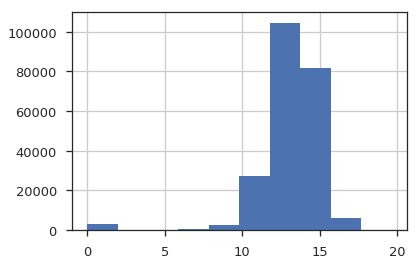

In [80]:
total_credit.map(np.log1p).hist();

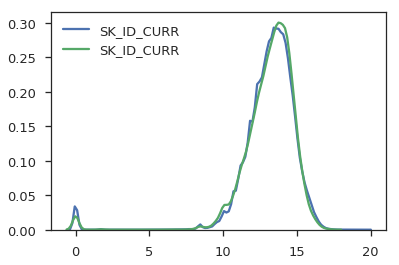

In [81]:
sns.kdeplot(total_credit[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(total_credit[app_train.TARGET == 1].map(np.log1p));

In [94]:
debt_to_credit_ratio = total_debt.div(total_credit, fill_value=np.nan).replace([-np.inf, np.inf], np.nan)
debt_to_credit_ratio[debt_to_credit_ratio.isnull()].shape[0] / len(debt_to_credit_ratio)

0.2783705298347051

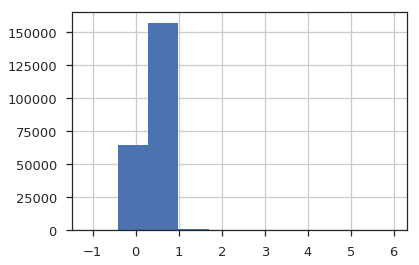

In [98]:
debt_to_credit_ratio.map(np.log1p).hist();

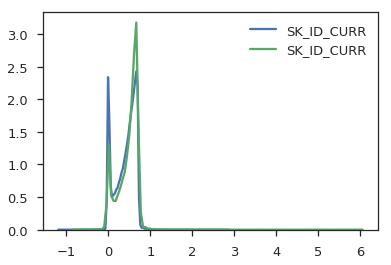

In [99]:
sns.kdeplot(debt_to_credit_ratio[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(debt_to_credit_ratio[app_train.TARGET == 1].map(np.log1p));

In [92]:
total_debt.head()

0    245781.0
1         0.0
2         NaN
3         NaN
4         NaN
Name: SK_ID_CURR, dtype: float64

In [93]:
total_credit.head()

0    481988.5625
1    810000.0000
2            NaN
3            NaN
4            NaN
Name: SK_ID_CURR, dtype: float64

### Differences between train and test set.

In [7]:
tr = app_train.loc[:, ['SK_ID_CURR']]\
              .merge(bureau.groupby('SK_ID_CURR', as_index=False)['DAYS_CREDIT'].min(), how='left')
te = app_test.loc[:, ['SK_ID_CURR']]\
             .merge(bureau.groupby('SK_ID_CURR', as_index=False)['DAYS_CREDIT'].min(), how='left')

In [10]:
tr[tr.DAYS_CREDIT.isnull()].shape[0] / len(tr), te[te.DAYS_CREDIT.isnull()].shape[0] / len(te)

(0.14314935075493235, 0.1317905793533563)

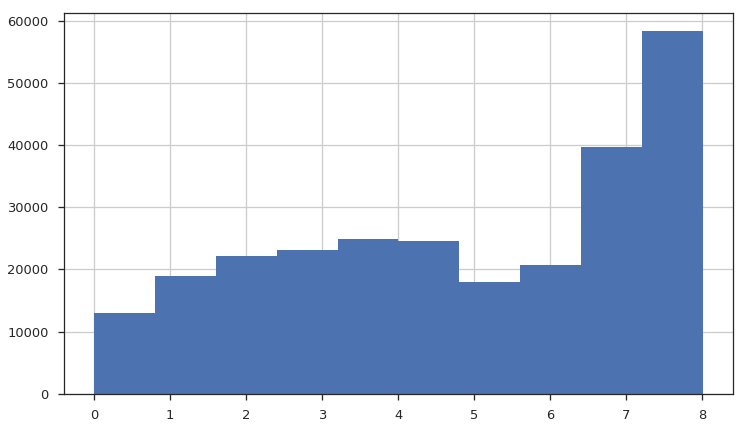

In [16]:
plt.figure(figsize=(12, 7))
(-tr[tr.DAYS_CREDIT.notnull()]['DAYS_CREDIT'] / 365).hist();

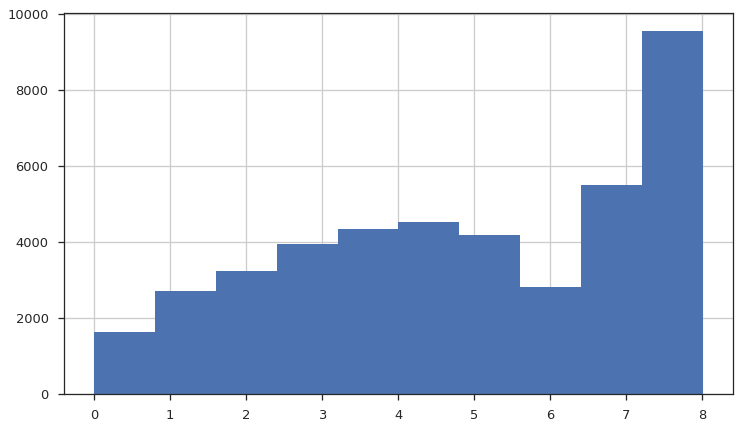

In [17]:
plt.figure(figsize=(12, 7))
(-te[te.DAYS_CREDIT.notnull()]['DAYS_CREDIT'] / 365).hist();

### Difference between train and test in terms of completed status 

In [26]:
%%time

current_status = bureau_bal.groupby('SK_ID_BUREAU', as_index=False)['MONTHS_BALANCE'].min()
current_status = bureau_bal.merge(current_status, how='inner')

CPU times: user 5.49 s, sys: 1.75 s, total: 7.24 s
Wall time: 7.25 s


In [27]:
current_status.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,-26,X
1,5715449,-11,X
2,5715451,-30,X
3,5715452,-32,X
4,5715453,-37,X


In [29]:
bbal = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']].merge(current_status, how='left')
bbal.head()

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,215354,5714462,NaN,NaN
1,215354,5714463,NaN,NaN
2,215354,5714464,NaN,NaN
3,215354,5714465,NaN,NaN
4,215354,5714466,NaN,NaN


In [49]:
recent_bbal = bbal[bbal.MONTHS_BALANCE.notnull()].groupby('SK_ID_CURR', as_index=False)['MONTHS_BALANCE'].min()
res         = bbal.loc[bbal.MONTHS_BALANCE.notnull(), ['SK_ID_CURR', 'MONTHS_BALANCE', 'STATUS']].merge(recent_bbal, how='inner')
res.head()

,SK_ID_CURR,MONTHS_BALANCE,STATUS
0,380361,-86.0,X
1,125263,-15.0,0
2,275240,-81.0,0
3,399518,-30.0,X
4,291600,-78.0,X


In [51]:
ss = pd.crosstab(res.STATUS.astype(np.str), app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

TARGET    0.0   1.0     ratio
STATUS                       
0       76832  6749  0.080748
1          50     2  0.038462
4           8     0  0.000000
5           6     3  0.333333
C         758    55  0.067651
X       62590  5646  0.082742


In [46]:
res = app_train.loc[:, ['SK_ID_CURR']].merge(res, how='inner')
res['STATUS'].value_counts(normalize=True)

0    0.580629
X    0.413419
C    0.005542
1    0.000306
5    0.000067
4    0.000038
3    0.000000
2    0.000000
Name: STATUS, dtype: float64

In [48]:
res = app_test.loc[:, ['SK_ID_CURR']].merge(res, how='inner')
res['STATUS'].value_counts(normalize=True)

X    0.519734
0    0.474875
C    0.004850
1    0.000416
4    0.000083
5    0.000042
3    0.000000
2    0.000000
Name: STATUS, dtype: float64

### Total Annuity to be paid

In [45]:
mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & (prev_app.CNT_PAYMENT > 0) &\
       ((-prev_app.DAYS_DECISION / 30) < (prev_app.CNT_PAYMENT))

total_prev_annuity = prev_app.loc[mask, :].groupby('SK_ID_CURR')['AMT_ANNUITY'].sum()
total_prev_annuity = app_train.SK_ID_CURR.map(total_prev_annuity)

current_annuity    = app_train.AMT_ANNUITY

total_annuity      = total_prev_annuity.add(current_annuity, fill_value=0)

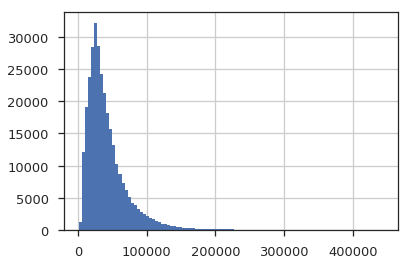

In [46]:
total_annuity.hist(bins=100);

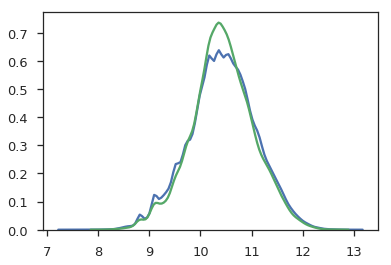

In [47]:
sns.kdeplot(total_annuity[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(total_annuity[app_train.TARGET == 1].map(np.log1p));

### Months still left on payment

In [58]:
mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & (prev_app.CNT_PAYMENT > 0) &\
       ((-prev_app.DAYS_DECISION / 30) < (prev_app.CNT_PAYMENT))

months_left_to_pay = (prev_app.loc[mask, 'CNT_PAYMENT']) - (-prev_app.loc[mask, 'DAYS_DECISION'] / 30) 
months_left_to_pay = months_left_to_pay.groupby(prev_app.loc[mask, 'SK_ID_CURR']).sum()

months_left_to_pay = app_train.SK_ID_CURR.map(months_left_to_pay)
months_left_to_pay[months_left_to_pay.isnull()].shape[0] / len(months_left_to_pay)

0.5046453622797233

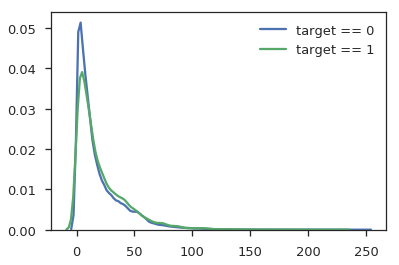

In [59]:
sns.kdeplot(months_left_to_pay[app_train.TARGET == 0], label='target == 0')
sns.kdeplot(months_left_to_pay[app_train.TARGET == 1], label='target == 1');

### Num nulls in external scores

In [62]:
null_str = app_train.loc[:, 'EXT_SOURCE_1'].isnull().astype(np.str) + '_' +\
           app_train.loc[:, 'EXT_SOURCE_2'].isnull().astype(np.str) + '_' +\
           app_train.loc[:, 'EXT_SOURCE_3'].isnull().astype(np.str)

In [64]:
ss = pd.crosstab(null_str, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
row_0,,,
False_False_False,101591,7998,0.072982
False_False_True,22297,2036,0.083672
False_True_False,136,17,0.111111
False_True_True,55,3,0.051724
True_False_False,125412,11115,0.081412
True_False_True,32778,3624,0.099555
True_True_False,259,18,0.064982
True_True_True,158,14,0.081395


### Relationship between annuity and credit for open credits

In [69]:
mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved') & (prev_app.CNT_PAYMENT > 0) &\
       ((-prev_app.DAYS_DECISION / 30) < (prev_app.CNT_PAYMENT))

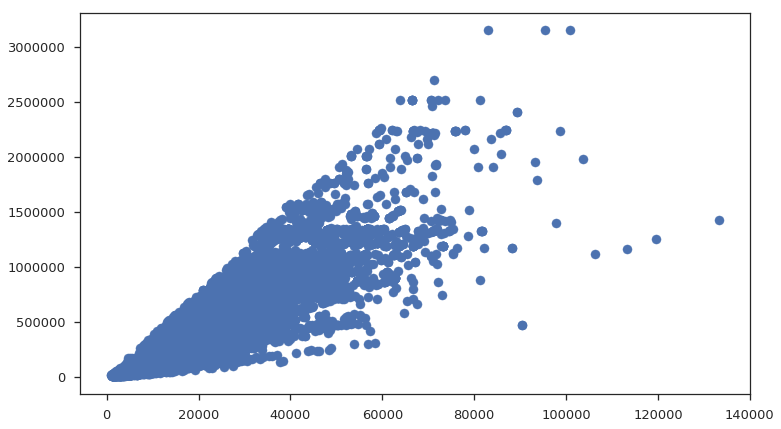

In [75]:
pos  = app_train.loc[app_train.TARGET == 1, ['SK_ID_CURR']]\
             .merge(prev_app.loc[mask, ['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_CREDIT']])

plt.figure(figsize=(12, 7))
plt.scatter(pos.AMT_ANNUITY, pos.AMT_CREDIT);

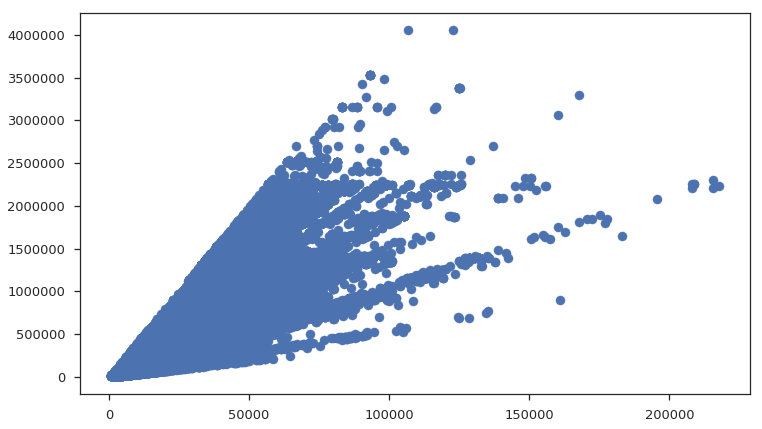

In [73]:
neg  = app_train.loc[app_train.TARGET == 0, ['SK_ID_CURR']]\
             .merge(prev_app.loc[mask, ['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_CREDIT']])

plt.figure(figsize=(12, 7))
plt.scatter(neg.AMT_ANNUITY, neg.AMT_CREDIT);

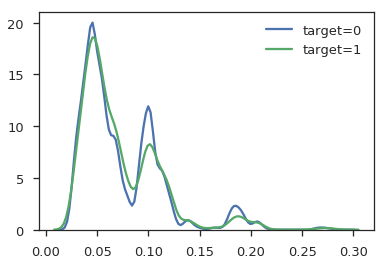

In [80]:
sns.kdeplot(neg.AMT_ANNUITY / neg.AMT_CREDIT, label='target=0')
sns.kdeplot(pos.AMT_ANNUITY / pos.AMT_CREDIT, label='target=1');

### Difference between actual and proposed termination

In [88]:
mask = (prev_app.DAYS_TERMINATION.notnull()) & (prev_app.DAYS_TERMINATION != 365243)

a = prev_app.loc[mask,'CNT_PAYMENT'] - (-prev_app.loc[mask, 'DAYS_DECISION'] / 30)
b = prev_app.loc[mask, 'DAYS_TERMINATION']

In [97]:
tmp = (a - b).groupby(prev_app.loc[mask, 'SK_ID_CURR']).mean()
tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.1316928500118695

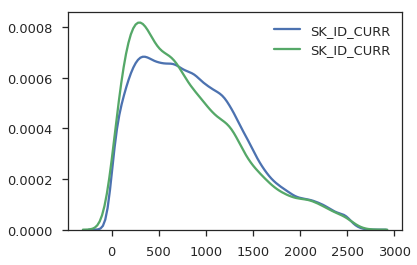

In [98]:
sns.kdeplot(tmp[app_train.TARGET == 0])
sns.kdeplot(tmp[app_train.TARGET == 1]);

### Relationship of Income Type and External Scores

In [12]:
app_train.groupby('NAME_INCOME_TYPE')['EXT_SOURCE_1'].mean()

NAME_INCOME_TYPE
Businessman             0.521973
Commercial associate    0.500488
Maternity leave         0.666016
Pensioner               0.692871
State servant           0.522949
Student                 0.420654
Unemployed              0.416748
Working                 0.466797
Name: EXT_SOURCE_1, dtype: float16

In [13]:
app_train.groupby('NAME_INCOME_TYPE')['EXT_SOURCE_2'].mean()

NAME_INCOME_TYPE
Businessman             0.666504
Commercial associate    0.541992
Maternity leave         0.512207
Pensioner               0.506348
State servant           0.534668
Student                 0.500000
Unemployed              0.459473
Working                 0.501953
Name: EXT_SOURCE_2, dtype: float16

In [14]:
app_train.groupby('NAME_INCOME_TYPE')['EXT_SOURCE_3'].mean()

NAME_INCOME_TYPE
Businessman             0.562988
Commercial associate    0.500000
Maternity leave              NaN
Pensioner               0.558594
State servant           0.514160
Student                 0.536621
Unemployed              0.463623
Working                 0.498535
Name: EXT_SOURCE_3, dtype: float16

### Family Type and Income Type with External Scores

In [10]:
fi1 = app_train.groupby(['NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'], as_index=False)['EXT_SOURCE_1'].mean()
tr  = app_train.loc[:, ['NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'TARGET']].merge(fi1, how='left')
tr.loc[:, 'diff_ext_1'] = tr.EXT_SOURCE_1 - app_train.EXT_SOURCE_1
tr.loc[:, 'old_ext_1']  = app_train.EXT_SOURCE_1

tr.loc[:, ['diff_ext_1', 'old_ext_1','TARGET']].corr()

,diff_ext_1,old_ext_1,TARGET
diff_ext_1,1.000000,-0.938910,0.148259
old_ext_1,-0.938910,1.000000,-0.155318
TARGET,0.148259,-0.155318,1.000000


### Family Type and Education Type with External Scores

In [23]:
fi1 = app_train.groupby(['NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE'], as_index=False)['EXT_SOURCE_1'].mean()
tr  = app_train.loc[:, ['NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'TARGET']].merge(fi1, how='left')
tr.loc[:, 'diff_ext_1'] = tr.EXT_SOURCE_1 - app_train.EXT_SOURCE_1
tr.loc[:, 'old_ext_1']  = app_train.EXT_SOURCE_1

tr.loc[:, ['diff_ext_1', 'old_ext_1', 'EXT_SOURCE_1','TARGET']].corr()

,diff_ext_1,old_ext_1,EXT_SOURCE_1,TARGET
diff_ext_1,1.000000,-0.970578,0.000195,0.145976
old_ext_1,-0.970578,1.000000,0.240599,-0.155318
EXT_SOURCE_1,0.000195,0.240599,1.000000,-0.059651
TARGET,0.145976,-0.155318,-0.059651,1.000000


### Relationship between Family Type, Occupation Type with External Scores

In [5]:
fi1 = app_train.groupby(['NAME_FAMILY_STATUS', 'OCCUPATION_TYPE'], as_index=False)['EXT_SOURCE_1'].mean()
tr  = app_train.loc[:, ['NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'TARGET']].merge(fi1, how='left')
tr.loc[:, 'diff_ext_1'] = tr.EXT_SOURCE_1 - app_train.EXT_SOURCE_1
tr.loc[:, 'old_ext_1']  = app_train.EXT_SOURCE_1

tr.loc[:, ['diff_ext_1', 'old_ext_1', 'EXT_SOURCE_1','TARGET']].corr()

,diff_ext_1,old_ext_1,EXT_SOURCE_1,TARGET
diff_ext_1,1.000000,-0.946498,-0.000057,0.138424
old_ext_1,-0.946498,1.000000,0.322763,-0.155318
EXT_SOURCE_1,-0.000057,0.322763,1.000000,-0.084490
TARGET,0.138424,-0.155318,-0.084490,1.000000


### Relationship between Family Type, Organization Type with External Scores

In [6]:
fi1 = app_train.groupby(['NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE'], as_index=False)['EXT_SOURCE_1'].mean()
tr  = app_train.loc[:, ['NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE', 'TARGET']].merge(fi1, how='left')
tr.loc[:, 'diff_ext_1'] = tr.EXT_SOURCE_1 - app_train.EXT_SOURCE_1
tr.loc[:, 'old_ext_1']  = app_train.EXT_SOURCE_1

tr.loc[:, ['diff_ext_1', 'old_ext_1', 'EXT_SOURCE_1','TARGET']].corr()

,diff_ext_1,old_ext_1,EXT_SOURCE_1,TARGET
diff_ext_1,1.000000,-0.931584,-0.000235,0.148637
old_ext_1,-0.931584,1.000000,0.363745,-0.155318
EXT_SOURCE_1,-0.000235,0.363745,1.000000,-0.062510
TARGET,0.148637,-0.155318,-0.062510,1.000000


### Number of late days in installments

In [18]:
is_late = installments.DAYS_INSTALMENT < installments.DAYS_ENTRY_PAYMENT
is_late = is_late.groupby(installments.SK_ID_CURR).sum()
is_late = app_train.SK_ID_CURR.map(is_late)

is_late[is_late.isnull()].shape[0] / len(is_late)

0.051601406128561254

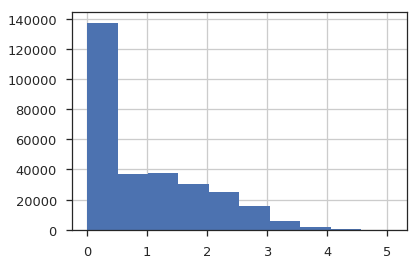

In [22]:
is_late.map(np.log1p).hist();

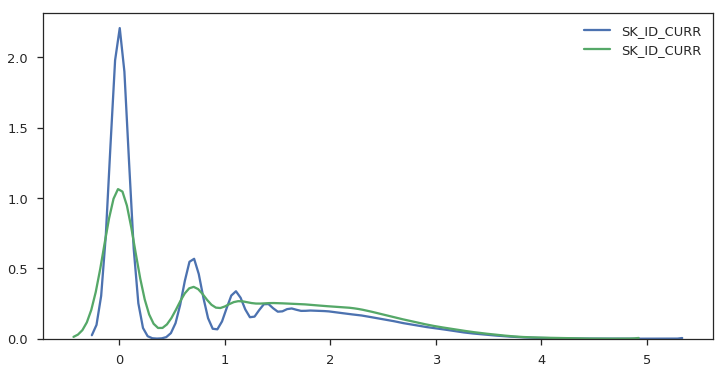

In [24]:
plt.figure(figsize=(12, 6))
sns.kdeplot(is_late[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(is_late[app_train.TARGET == 1].map(np.log1p));

### Total Amount Paid in Installments and compare it with credit

In [78]:
mask = prev_app.NAME_CONTRACT_STATUS == 'Approved'

x = prev_app.loc[mask, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT']]\
        .merge(installments.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_PAYMENT']])

x = x.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False).agg({'AMT_CREDIT': np.mean,
                                                             'AMT_PAYMENT': np.sum
                                                            })

x.loc[:, 'diff_payment_credit'] = x.AMT_PAYMENT - x.AMT_CREDIT
x = x.groupby('SK_ID_CURR')['diff_payment_credit'].min()
x = app_train.SK_ID_CURR.map(x)

x[x.isnull()].shape[0] / len(x)

0.058875942649206044

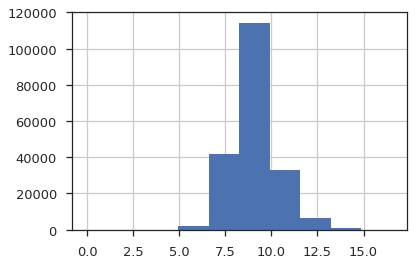

In [79]:
x.map(np.log1p).hist();

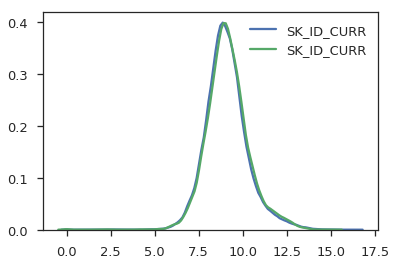

In [80]:
sns.kdeplot(x[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(x[app_train.TARGET == 1].map(np.log1p));

### Difference between current payment and length of installments

In [82]:
mask = prev_app.NAME_CONTRACT_STATUS == 'Approved'

x = prev_app.loc[mask].groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['CNT_PAYMENT'].sum()
inst_x = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV']).size().reset_index().rename(columns={0: 'inst_size'})

,SK_ID_CURR,SK_ID_PREV,inst_size
0,100001,1369693,4
1,100001,1851984,3
2,100002,1038818,19
3,100003,1810518,7
4,100003,2396755,12


In [83]:
y = x.merge(inst_x); y.head()

,SK_ID_CURR,SK_ID_PREV,CNT_PAYMENT,inst_size
0,100001,1369693,8.0,4
1,100002,1038818,24.0,19
2,100003,1810518,12.0,7
3,100003,2396755,12.0,12
4,100003,2636178,6.0,6


In [84]:
y.loc[:, 'diff'] = y.CNT_PAYMENT - y.inst_size
tmp = y.groupby('SK_ID_CURR')['diff'].sum()
tmp = app_train.SK_ID_CURR.map(tmp)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.058875942649206044

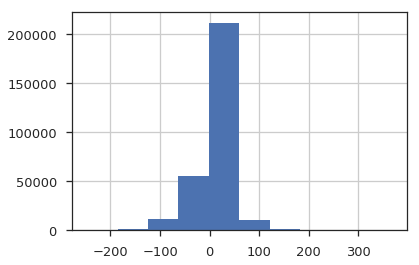

In [86]:
tmp.hist();

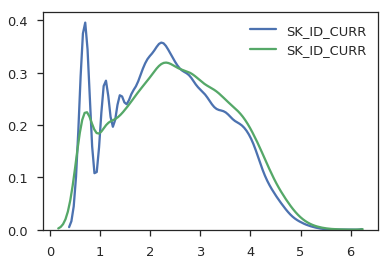

In [89]:
sns.kdeplot(tmp[(tmp > 0) & (app_train.TARGET == 0)].map(np.log1p))
sns.kdeplot(tmp[(tmp > 0) & (app_train.TARGET == 1)].map(np.log1p))

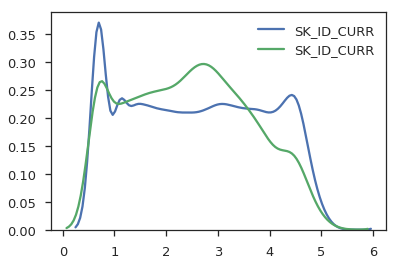

In [91]:
sns.kdeplot((-tmp[(tmp < 0) & (app_train.TARGET == 0)]).map(np.log1p))
sns.kdeplot((-tmp[(tmp < 0) & (app_train.TARGET == 1)]).map(np.log1p));

### Comparison of Bureau Credit History for Customers in training and test set.

In [6]:
bur_tr = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']].merge(bureau_bal.loc[:, ['SK_ID_BUREAU']], how='inner')
bur_tr = bur_tr.groupby('SK_ID_CURR').size()

tr = app_train.SK_ID_CURR.map(bur_tr)
te = app_test.SK_ID_CURR.map(bur_tr)

del bur_tr
gc.collect();

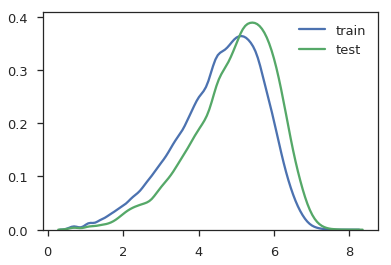

In [10]:
sns.kdeplot(tr.map(np.log1p), label='train')
sns.kdeplot(te.map(np.log1p), label='test');

### Comparison of previous home credits for customers in train and test

In [11]:
prev_app_tr = prev_app.groupby('SK_ID_CURR').size()
tr = app_train.SK_ID_CURR.map(prev_app_tr)
te = app_test.SK_ID_CURR.map(prev_app_tr)

del prev_app_tr
gc.collect();

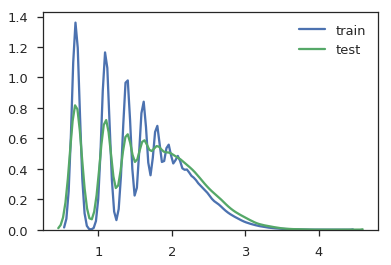

In [13]:
sns.kdeplot(tr.map(np.log1p), label='train')
sns.kdeplot(te.map(np.log1p), label='test');

### Relation between credit status and actual credit enddate for bureau

In [41]:
mask = (bureau.CREDIT_ACTIVE == 'Active') &\
       (bureau.DAYS_CREDIT_ENDDATE < 0)

num_ended_but_still_active = bureau.loc[mask].groupby('SK_ID_CURR').size()
num_ended_but_still_active = app_train.SK_ID_CURR.map(num_ended_but_still_active).fillna(0)

num_ended_but_still_active[num_ended_but_still_active.isnull()].shape[0] / len(num_ended_but_still_active)

0.0

### Relationship between total debt from bureau credits with age

In [66]:
mask = (bureau.CREDIT_ACTIVE == 'Active') & (bureau.DAYS_CREDIT_ENDDATE > 0)
total_debt_bureau   = bureau.loc[mask, :].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()
total_credit_bureau = bureau.loc[mask, :].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

total_debt_bureau   = app_train.SK_ID_CURR.map(total_debt_bureau)
total_credit_bureau = app_train.SK_ID_CURR.map(total_credit_bureau) 

total_debt_bureau[total_debt_bureau.isnull()].shape[0] / len(total_debt_bureau)

0.40226203290288803

In [67]:
tmp = (total_debt_bureau / total_credit_bureau) * (-app_train.DAYS_BIRTH / 365)

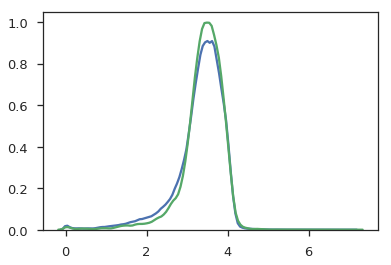

In [68]:
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

### Relationship between age and external credit scores.

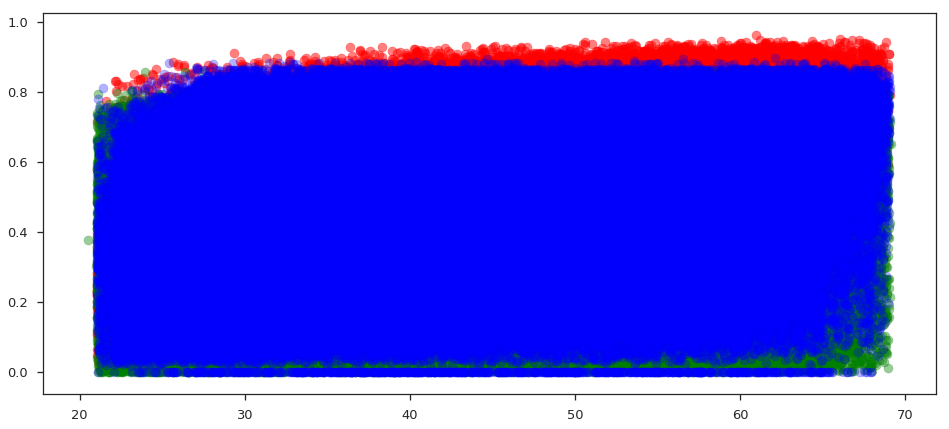

In [11]:
plt.figure(figsize=(16, 7))
plt.scatter(-app_train.DAYS_BIRTH / 365, app_train.EXT_SOURCE_1, c='r', alpha=.5)
plt.scatter(-app_train.DAYS_BIRTH / 365, app_train.EXT_SOURCE_2, c='g', alpha=.4)
plt.scatter(-app_train.DAYS_BIRTH / 365, app_train.EXT_SOURCE_3, c='b', alpha=.3);

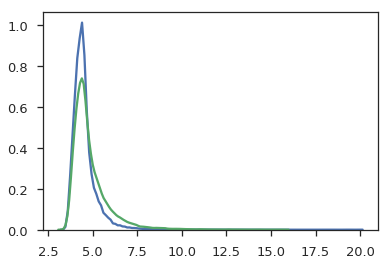

In [18]:
sns.kdeplot(((-app_train.DAYS_BIRTH / 365) / app_train.EXT_SOURCE_2)[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(((-app_train.DAYS_BIRTH / 365) / app_train.EXT_SOURCE_2)[app_train.TARGET == 1].map(np.log1p));

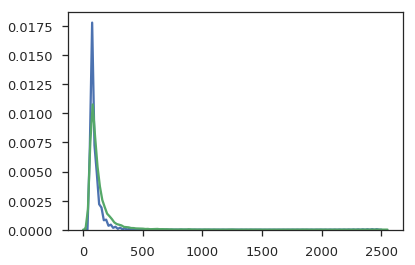

In [16]:
sns.kdeplot(((-app_train.DAYS_BIRTH / 365) / app_train.EXT_SOURCE_1)[app_train.TARGET == 0])
sns.kdeplot(((-app_train.DAYS_BIRTH / 365) / app_train.EXT_SOURCE_1)[app_train.TARGET == 1]);

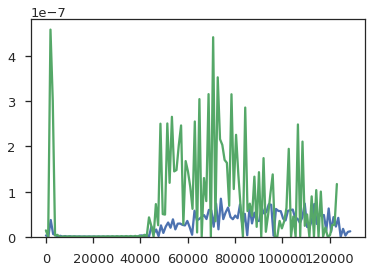

In [15]:
sns.kdeplot(((-app_train.DAYS_BIRTH / 365) / app_train.EXT_SOURCE_3)[app_train.TARGET == 0])
sns.kdeplot(((-app_train.DAYS_BIRTH / 365) / app_train.EXT_SOURCE_3)[app_train.TARGET == 1]);

### Relationship between enddate and employed since

In [22]:
x = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') & (bureau.DAYS_CREDIT_ENDDATE > 0)]
mean_enddate = x.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].sum()

mean_enddate = app_train.SK_ID_CURR.map(mean_enddate)
tmp  = mean_enddate / (-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.4723603383293606

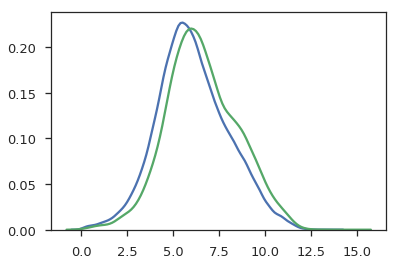

In [23]:
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

### High Credit vs Low Credit Buyer Behavior

In [57]:
app_train.AMT_CREDIT.describe()

count    3.075110e+05
mean     5.988308e+05
std      4.024795e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

In [69]:
# number of active bureau credits
mask = (bureau.CREDIT_ACTIVE == 'Active') & (bureau.DAYS_CREDIT_ENDDATE > 0)

total_credit = bureau.loc[mask, :].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

low_credit  = app_train.loc[app_train.AMT_CREDIT < 3e5, 'SK_ID_CURR'].map(total_credit)
high_credit = app_train.loc[app_train.AMT_CREDIT > 8e5, 'SK_ID_CURR'].map(total_credit) 

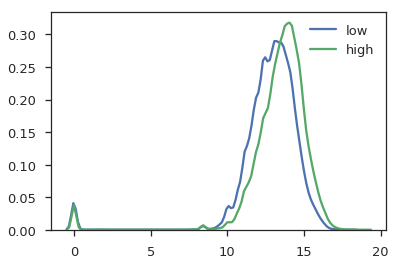

In [71]:
sns.kdeplot(low_credit.map(np.log1p), label='low')
sns.kdeplot(high_credit.map(np.log1p), label='high');

In [125]:
mask = (bureau.CREDIT_ACTIVE == 'Active') & (bureau.DAYS_CREDIT_ENDDATE > 0)

mean_credit = bureau.loc[mask, :].groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].min()
mean_credit = app_train.SK_ID_CURR.map(mean_credit)

mean_debt = bureau.loc[mask, :].groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].min()
mean_debt = app_train.SK_ID_CURR.map(mean_debt)

tmp         = (mean_debt / mean_credit) * (app_train.EXT_SOURCE_3)

tmp[tmp.isnull()].shape[0] / len(tmp)

0.46191843543808186

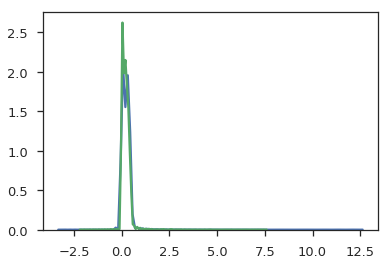

In [126]:
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

### Analyze customers who have income type as pension

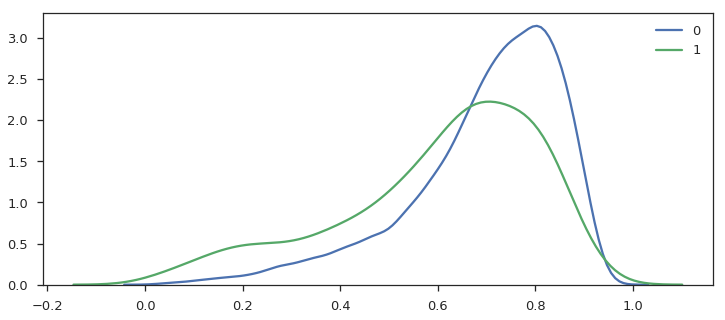

In [29]:
plt.figure(figsize=(12, 5))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_1'], label='0')
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_1'], label='1');

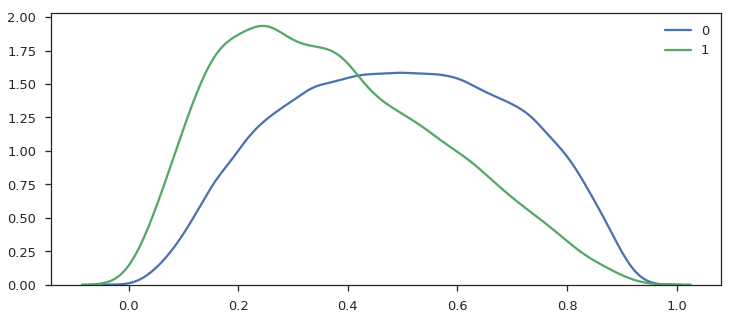

In [30]:
plt.figure(figsize=(12, 5))

mask = (app_train.NAME_INCOME_TYPE != 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_1'], label='0')
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_1'], label='1');

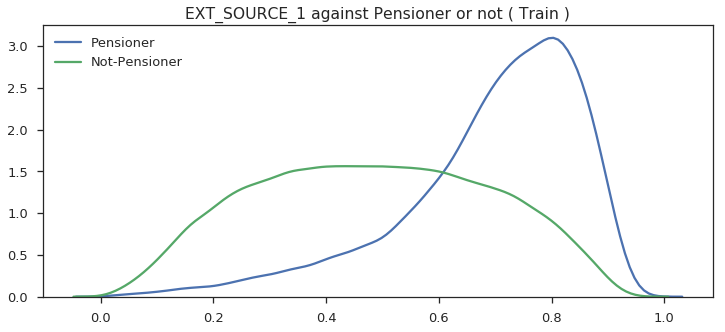

In [31]:
plt.figure(figsize=(12, 5))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask, 'EXT_SOURCE_1'], label='Pensioner')
sns.kdeplot(app_train.loc[~mask, 'EXT_SOURCE_1'], label='Not-Pensioner')
plt.title('EXT_SOURCE_1 against Pensioner or not ( Train )');

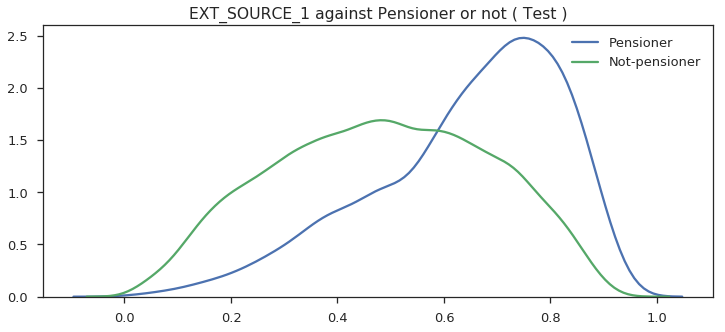

In [32]:
plt.figure(figsize=(12, 5))

mask = (app_test.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_test.loc[mask, 'EXT_SOURCE_1'], label='Pensioner')
sns.kdeplot(app_test.loc[~mask, 'EXT_SOURCE_1'], label='Not-pensioner')
plt.title('EXT_SOURCE_1 against Pensioner or not ( Test )');

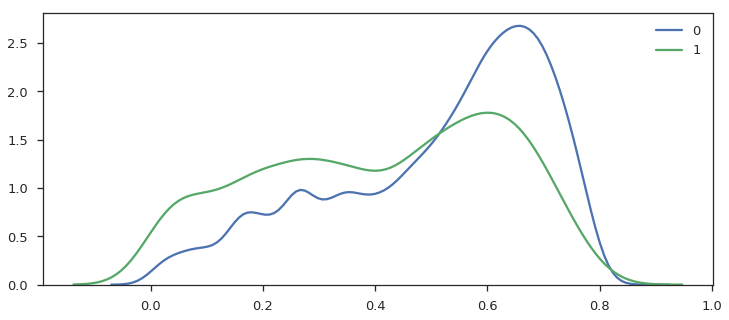

In [33]:
plt.figure(figsize=(12, 5))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_2'], label='0')
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_2'], label='1');

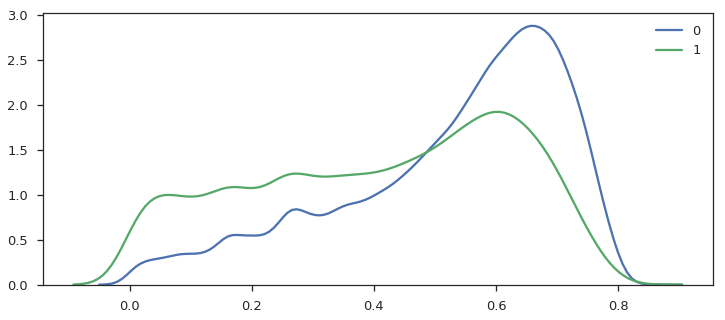

In [34]:
plt.figure(figsize=(12, 5))

mask = (app_train.NAME_INCOME_TYPE != 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_2'], label='0')
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_2'], label='1');

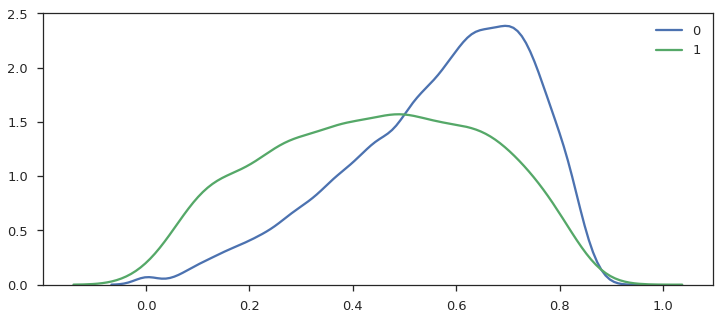

In [35]:
plt.figure(figsize=(12, 5))

mask = (app_train.NAME_INCOME_TYPE == 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_3'], label='0')
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_3'], label='1');

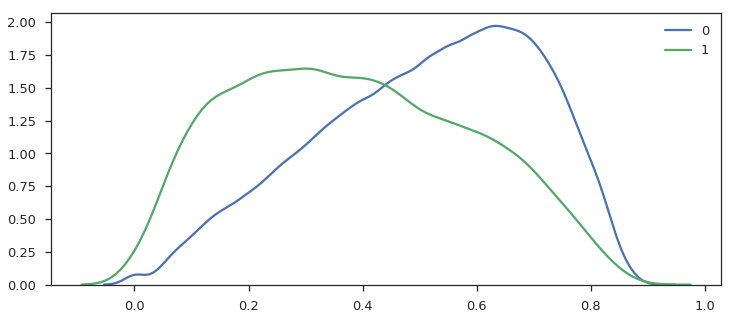

In [36]:
plt.figure(figsize=(12, 5))

mask = (app_train.NAME_INCOME_TYPE != 'Pensioner')

sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 0), 'EXT_SOURCE_3'], label='0')
sns.kdeplot(app_train.loc[mask & (app_train.TARGET == 1), 'EXT_SOURCE_3'], label='1');

In [47]:
app_train['EXT_SOURCE_1'].astype(np.float32).mean()

0.5021324753761292

In [48]:
app_train['EXT_SOURCE_2'].mean()

nan

In [50]:
m   = app_train.groupby('NAME_INCOME_TYPE')['EXT_SOURCE_1'].mean()
tmp = app_train.NAME_INCOME_TYPE.map(m)

tmp = tmp / app_train['EXT_SOURCE_1']
pd.DataFrame({'f': tmp, 't': app_train.TARGET}).corr()

,f,t
f,1.000000,0.153676
t,0.153676,1.000000


In [63]:
m   = app_train.groupby('NAME_INCOME_TYPE')['EXT_SOURCE_1'].mean()
tmp = app_train.NAME_INCOME_TYPE.map(m)

tmp = tmp / app_train['EXT_SOURCE_1']
pd.DataFrame({'f': tmp, 'p': app_train.EXT_SOURCE_1, 't': app_train.TARGET}).corr()

,f,p,t
f,1.000000,-0.666162,0.153676
p,-0.666162,1.000000,-0.155318
t,0.153676,-0.155318,1.000000


In [56]:
app_train.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']].corr()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_1,1.000000,0.213984,0.186842,-0.155318
EXT_SOURCE_2,0.213984,1.000000,0.109166,-0.160471
EXT_SOURCE_3,0.186842,0.109166,1.000000,-0.178918
TARGET,-0.155318,-0.160471,-0.178918,1.000000


### Geometric mean of external source

In [12]:
gm = np.power(app_train.EXT_SOURCE_1 * app_train.EXT_SOURCE_2 * app_train.EXT_SOURCE_3, 1 / 3)

gm12 = np.power(app_train.EXT_SOURCE_1 * app_train.EXT_SOURCE_2, 1 / 2)
gm23 = np.power(app_train.EXT_SOURCE_2 * app_train.EXT_SOURCE_3, 1 / 2)
gm13 = np.power(app_train.EXT_SOURCE_1 * app_train.EXT_SOURCE_3, 1 / 2)

x  = pd.DataFrame({'t': app_train.TARGET, 
                   'ext1': app_train.EXT_SOURCE_1,
                   'ext2': app_train.EXT_SOURCE_2,
                   'ext3': app_train.EXT_SOURCE_3,
                   'gm': gm,
                   'gm12': gm12,
                   'gm23': gm23,
                   'gm13': gm13
                  })
x.corr()

,t,ext1,ext2,ext3,gm,gm12,gm23,gm13
t,1.000000,-0.155318,-0.160471,-0.178918,-0.232678,-0.193732,-0.218735,-0.210754
ext1,-0.155318,1.000000,0.213984,0.186842,0.680340,0.790969,0.250154,0.762603
ext2,-0.160471,0.213984,1.000000,0.109166,0.627803,0.741936,0.729892,0.205748
ext3,-0.178918,0.186842,0.109166,1.000000,0.646311,0.194812,0.727326,0.753814
gm,-0.232678,0.680340,0.627803,0.646311,1.000000,0.855542,0.867111,0.874379
gm12,-0.193732,0.790969,0.741936,0.194812,0.855542,1.000000,0.603439,0.636283
gm23,-0.218735,0.250154,0.729892,0.727326,0.867111,0.603439,1.000000,0.650670
gm13,-0.210754,0.762603,0.205748,0.753814,0.874379,0.636283,0.650670,1.000000


### Relationship between maximum and minimum installment during the course of payment for previous credit applications

In [107]:
max_installment = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['AMT_INSTALMENT'].max()
min_installment = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['AMT_INSTALMENT'].min()

ratio_max_min   = max_installment.divide(min_installment, fill_value=np.nan).replace([-np.inf, np.inf], np.nan)

In [117]:
tmp = ratio_max_min.reset_index()
tmp = tmp.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

tmp = app_train.SK_ID_CURR.map(tmp)
tmp[tmp.isnull()].shape[0] / len(tmp)

0.051601406128561254

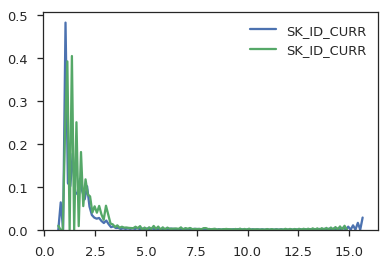

In [116]:
sns.kdeplot(tmp[(app_train.TARGET == 0)].map(np.log1p))
sns.kdeplot(tmp[(app_train.TARGET == 1)].map(np.log1p));

In [57]:
tmp[(app_train.TARGET == 0)].map(np.log1p).value_counts().iloc[:10]

0.000000    13862
4.879007      312
0.753772      161
0.431808      121
0.996934      119
0.460560      108
1.164736      107
0.732405      106
1.475907      105
0.488508      102
Name: SK_ID_CURR, dtype: int64

In [58]:
tmp[(app_train.TARGET == 1)].map(np.log1p).value_counts().iloc[:10]

0.000000    1516
4.879007      41
0.753772      25
0.774691      18
0.126426      18
0.980219      16
0.732405      15
0.795182      14
0.928327      14
0.203021      14
Name: SK_ID_CURR, dtype: int64

### Relationship between installment amount and credit amount

In [79]:
tmp = installments.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False).agg({'AMT_INSTALMENT': [len, np.mean]})
tmp.columns = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_INSTALMENT_CNT', 'AMT_INSTALMENT_MEAN']

tmp = prev_app.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT', 'CNT_PAYMENT']]\
              .merge(tmp, how='inner'); tmp.head()

,SK_ID_CURR,SK_ID_PREV,AMT_CREDIT,CNT_PAYMENT,AMT_INSTALMENT_CNT,AMT_INSTALMENT_MEAN
0,271877,2030495,17145.0,12.0,1.0,17284.275391
1,108129,2802425,679671.0,36.0,5.0,25188.615234
2,122040,2523466,136444.5,12.0,9.0,15060.735352
3,176158,2819243,470790.0,12.0,11.0,51193.945312
4,199383,1383531,340573.5,18.0,20.0,20966.644531


In [105]:
tmp.loc[:, 'ratio_credit_installment'] = tmp.AMT_CREDIT / (tmp.AMT_INSTALMENT_MEAN * tmp.AMT_INSTALMENT_CNT)
tmp.loc[:, 'diff_cnt_payment_actual']  = tmp.CNT_PAYMENT - tmp.AMT_INSTALMENT_CNT

# res = tmp.groupby('SK_ID_CURR')['ratio_credit_installment'].max()
res = tmp.groupby('SK_ID_CURR')['diff_cnt_payment_actual'].max()

res = app_train.SK_ID_CURR.map(res)
res[res.isnull()].shape[0] / len(res)

0.058875942649206044

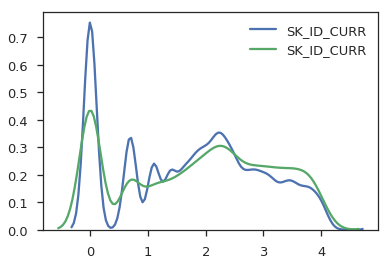

In [106]:
sns.kdeplot(res[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(res[app_train.TARGET == 1].map(np.log1p));

### Relationship between external scores and target variable

In [13]:
mask = (app_train.TARGET == 1) & (app_train.EXT_SOURCE_2 >= .6)

app_train.loc[mask, 'NAME_INCOME_TYPE'].value_counts(normalize=True)

Working                 0.555103
Commercial associate    0.264731
Pensioner               0.121583
State servant           0.058244
Unemployed              0.000340
Student                 0.000000
Maternity leave         0.000000
Businessman             0.000000
Name: NAME_INCOME_TYPE, dtype: float64

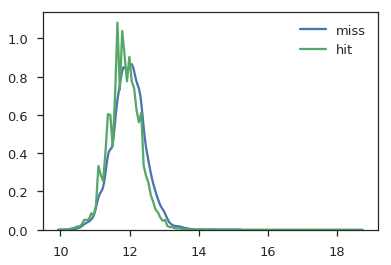

In [25]:
# income
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 >= .6), 'AMT_INCOME_TOTAL'].map(np.log1p), label='miss')
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 < .6), 'AMT_INCOME_TOTAL'].map(np.log1p), label='hit');

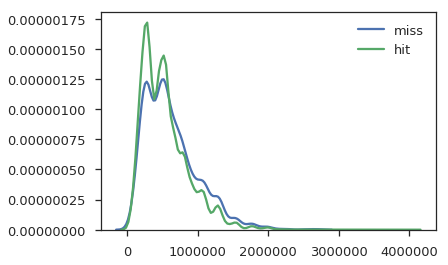

In [26]:
# credit
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 >= .6), 'AMT_CREDIT'], label='miss')
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 < .6), 'AMT_CREDIT'], label='hit');

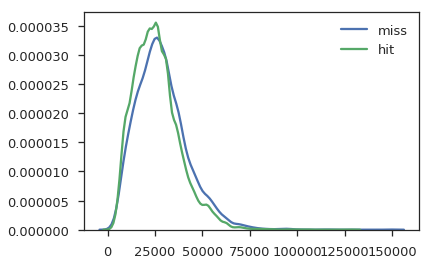

In [27]:
# annuity
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 >= .6), 'AMT_ANNUITY'], label='miss')
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 < .6), 'AMT_ANNUITY'], label='hit');

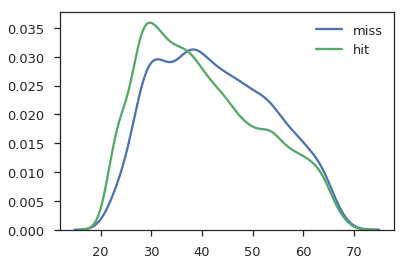

In [30]:
# age
sns.kdeplot(-app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 >= .6), 'DAYS_BIRTH'] / 365, label='miss')
sns.kdeplot(-app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 < .6), 'DAYS_BIRTH'] / 365, label='hit');

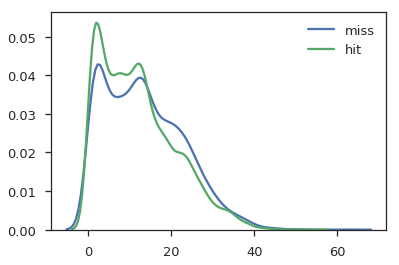

In [31]:
# days registration
sns.kdeplot(-app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 >= .6), 'DAYS_REGISTRATION'] / 365, label='miss')
sns.kdeplot(-app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 < .6), 'DAYS_REGISTRATION'] / 365, label='hit');

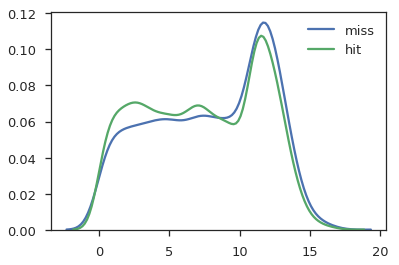

In [32]:
# days id publish
sns.kdeplot(-app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 >= .6), 'DAYS_ID_PUBLISH'] / 365, label='miss')
sns.kdeplot(-app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 < .6), 'DAYS_ID_PUBLISH'] / 365, label='hit');

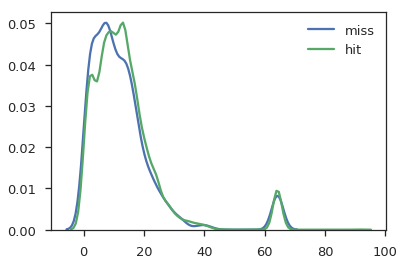

In [34]:
# car age
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 >= .6), 'OWN_CAR_AGE'], label='miss')
sns.kdeplot(app_train.loc[(app_train.TARGET == 1) &\
                          (app_train.EXT_SOURCE_2 < .6), 'OWN_CAR_AGE'], label='hit');

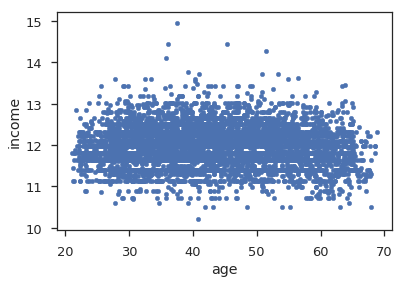

In [37]:
# age and income
x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 >= .6), ['DAYS_BIRTH', 'AMT_INCOME_TOTAL']]

x.loc[:, 'age']    = -x.DAYS_BIRTH / 365
x.loc[:, 'income'] = x.AMT_INCOME_TOTAL.map(np.log1p) 

x.loc[:, ['age', 'income']].plot.scatter(x='age', y='income');

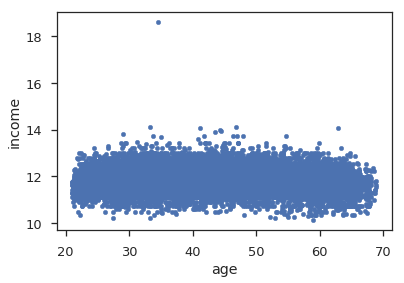

In [38]:
x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 < .6), ['DAYS_BIRTH', 'AMT_INCOME_TOTAL']]

x.loc[:, 'age']    = -x.DAYS_BIRTH / 365
x.loc[:, 'income'] = x.AMT_INCOME_TOTAL.map(np.log1p) 

x.loc[:, ['age', 'income']].plot.scatter(x='age', y='income');

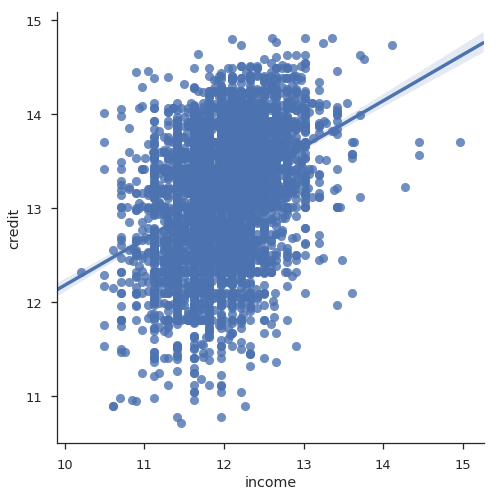

In [42]:
# credit and income

x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 >= .6), ['AMT_CREDIT', 'AMT_INCOME_TOTAL']]

x.loc[:, 'credit'] = x.AMT_CREDIT.map(np.log1p)
x.loc[:, 'income'] = x.AMT_INCOME_TOTAL.map(np.log1p)

sns.lmplot('income', 'credit', x, size=7);

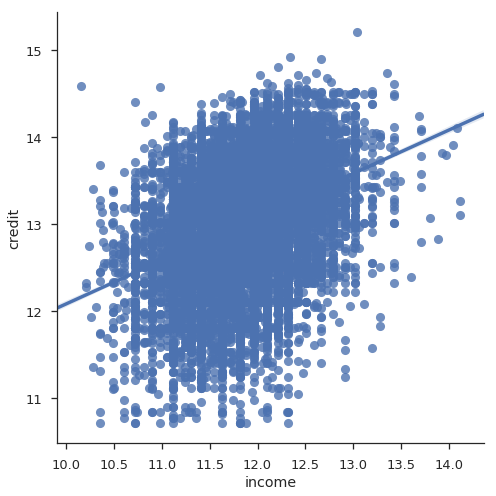

In [44]:
# credit and income

x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 < .6), ['AMT_CREDIT', 'AMT_INCOME_TOTAL']]

x.loc[:, 'credit'] = x.AMT_CREDIT.map(np.log1p)
x.loc[:, 'income'] = x.AMT_INCOME_TOTAL.map(np.log1p)

sns.lmplot('income', 'credit', x[x.income < 16], size=7);

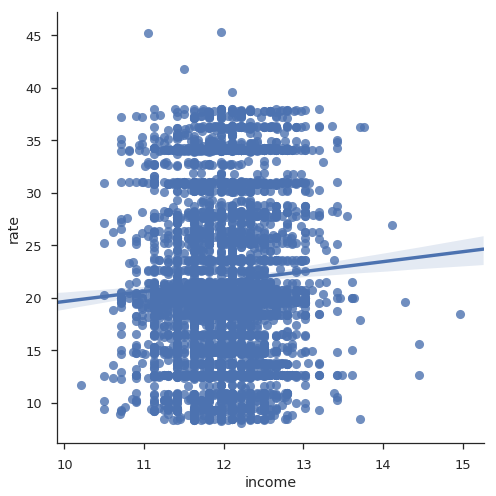

In [45]:
# rate and income

x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 >= .6), ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']]

x.loc[:, 'rate']   = x.AMT_CREDIT / x.AMT_ANNUITY
x.loc[:, 'income'] = x.AMT_INCOME_TOTAL.map(np.log1p)

sns.lmplot('income', 'rate', x, size=7);

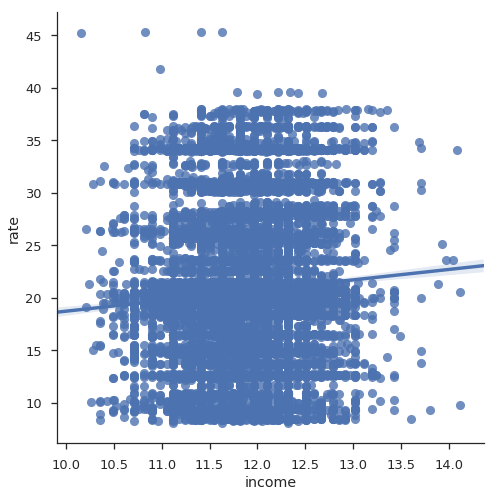

In [47]:
# rate and income

x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 < .6), ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']]

x.loc[:, 'rate']   = x.AMT_CREDIT / x.AMT_ANNUITY
x.loc[:, 'income'] = x.AMT_INCOME_TOTAL.map(np.log1p)

sns.lmplot('income', 'rate', x[x.income < 16], size=7);

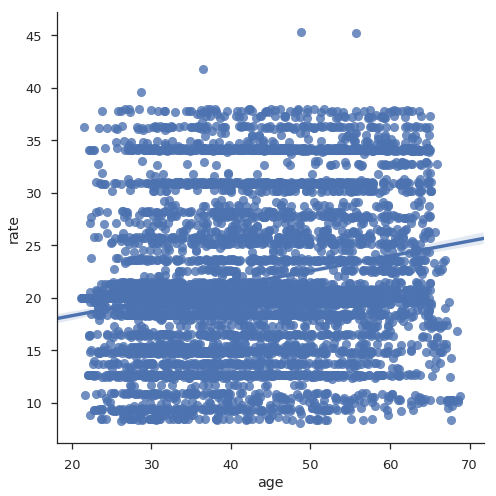

In [48]:
# rate and age

x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 >= .6), ['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH']]

x.loc[:, 'rate']   = x.AMT_CREDIT / x.AMT_ANNUITY
x.loc[:, 'age']    = -x.DAYS_BIRTH /365

sns.lmplot('age', 'rate', x, size=7);

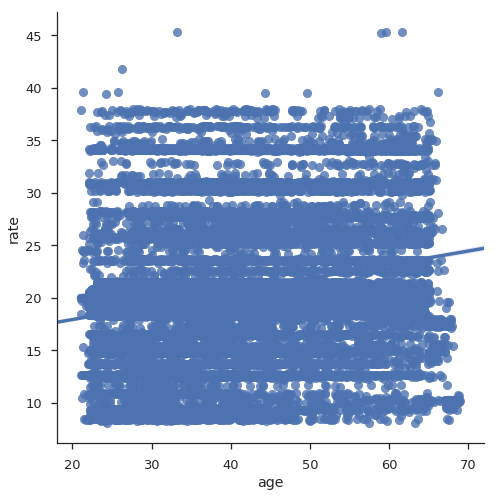

In [49]:
# rate and age

x = app_train.loc[(app_train.TARGET == 1) &\
              (app_train.EXT_SOURCE_2 < .6), ['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH']]

x.loc[:, 'rate']   = x.AMT_CREDIT / x.AMT_ANNUITY
x.loc[:, 'age']    = -x.DAYS_BIRTH /365

sns.lmplot('age', 'rate', x, size=7);

### Previous Credit approval trends

In [101]:
def plot_prev_credit_durations(ax, x, SK_ID_CURR, target):    
    t = x[x.SK_ID_CURR == SK_ID_CURR].sort_values(by=['DAYS_DECISION'], ascending=False).loc[:, ['DAYS_DECISION', 'DAYS_TERMINATION']]
    t.index = np.arange(len(t))

    t.DAYS_DECISION.plot(ax=ax)
    t.DAYS_TERMINATION.plot(ax=ax)

In [114]:
x = app_train[app_train.TARGET == 1]\
             .merge(prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                                 (prev_app.DAYS_TERMINATION.notnull()) &\
                                 (prev_app.DAYS_TERMINATION != 365243.0)
                                ], on='SK_ID_CURR', how='inner')

defaulters = x.sample(n=100, random_state=SEED).SK_ID_CURR.values
defaulters

array([414337, 254747, 305482, 248474, 338699, 425184, 262422, 288901,
       233073, 315795, 207431, 133627, 262624, 141992, 454431, 236647,
       450698, 105788, 166718, 257666, 425234, 189542, 247520, 236633,
       215572, 149261, 299444, 142122, 380089, 296640, 118362, 204089,
       279333, 348543, 226575, 312811, 177000, 413762, 331175, 131297,
       148234, 448592, 279057, 397196, 284289, 263049, 382547, 107128,
       171013, 340209, 361103, 346643, 329813, 444176, 326889, 133157,
       455330, 194311, 358356, 237919, 394102, 262223, 235315, 104989,
       263592, 252132, 293938, 249276, 287661, 222136, 330778, 355176,
       138005, 268670, 365296, 159109, 416181, 164338, 418553, 275063,
       301951, 444960, 193355, 211610, 436990, 424547, 290708, 265401,
       363442, 176647, 232261, 257351, 110614, 305073, 391238, 186146,
       214860, 105181, 396956, 137609], dtype=int32)

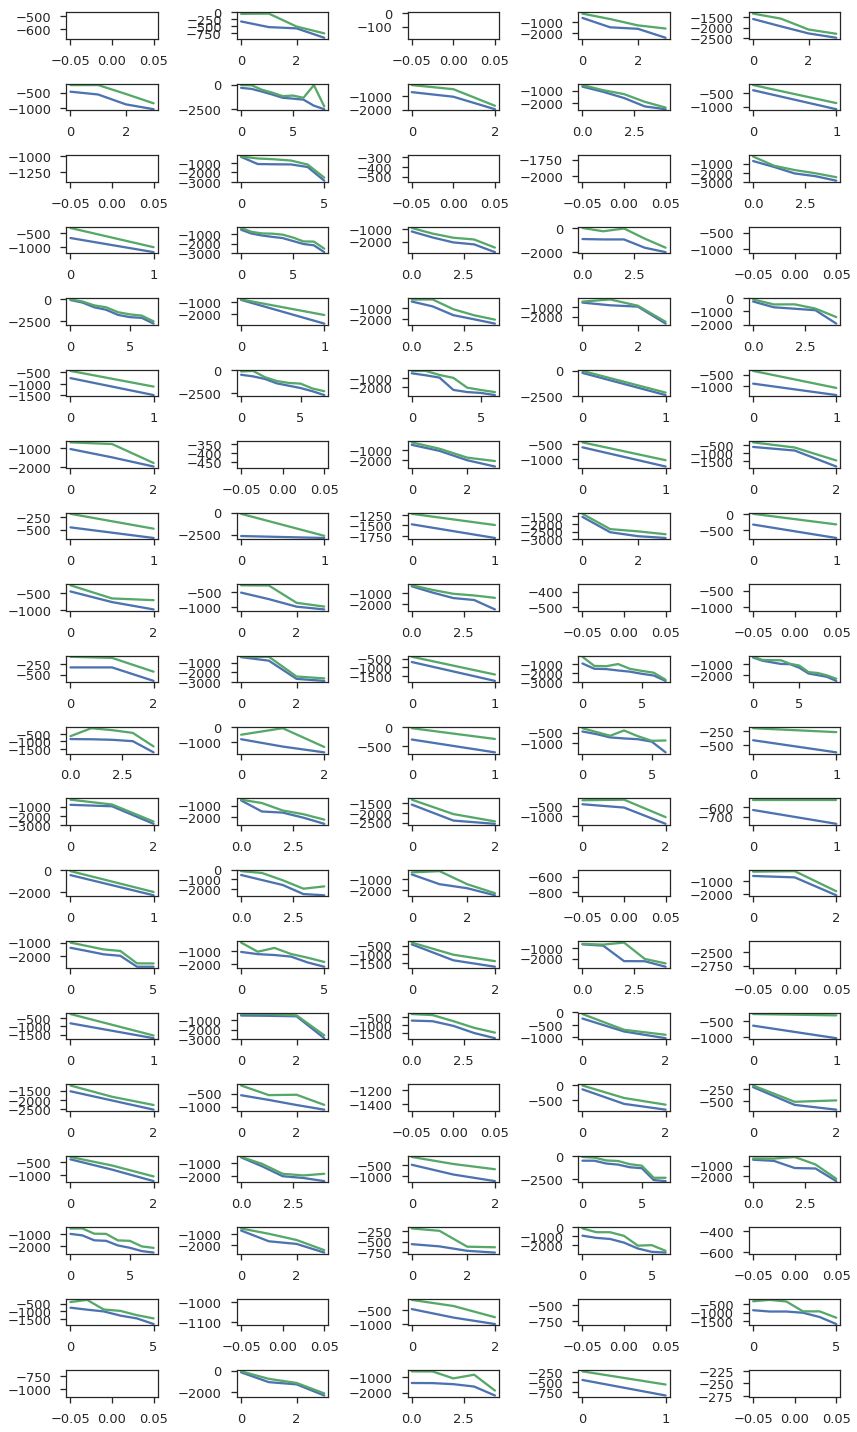

In [118]:
fig = plt.figure(figsize=(12, 20))

for i in range(1, 101):
    SK_ID_CURR = defaulters[i-1]
    ax = fig.add_subplot(20, 5, i)
    plot_prev_credit_durations(ax, x, SK_ID_CURR, 1)
    
plt.tight_layout();

In [119]:
x = app_train[app_train.TARGET == 0]\
             .merge(prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                                 (prev_app.DAYS_TERMINATION.notnull()) &\
                                 (prev_app.DAYS_TERMINATION != 365243.0)
                                ], on='SK_ID_CURR', how='inner')

non_defaulters = x.sample(n=100, random_state=SEED).SK_ID_CURR.values
non_defaulters

array([163819, 369667, 126894, 383857, 219790, 207985, 407116, 454692,
       278177, 419518, 247037, 213467, 206144, 326788, 327437, 386423,
       221163, 357736, 408981, 314044, 297975, 298936, 130725, 219809,
       411670, 211033, 101893, 416732, 421181, 200232, 136896, 328525,
       315650, 366993, 343852, 247432, 239756, 355097, 154209, 363620,
       433378, 378185, 346579, 168643, 367737, 221077, 271437, 222364,
       383813, 157275, 273361, 412933, 172617, 214001, 333648, 223033,
       439691, 173111, 174706, 313118, 136007, 308759, 420226, 100135,
       381102, 220853, 148541, 296464, 217626, 243521, 208904, 116839,
       360121, 104415, 440527, 155065, 280427, 292024, 429132, 299688,
       277166, 255895, 281432, 205959, 358897, 135748, 416017, 251779,
       444422, 235387, 211664, 189459, 127540, 326718, 364406, 412025,
       447574, 354369, 238781, 142754], dtype=int32)

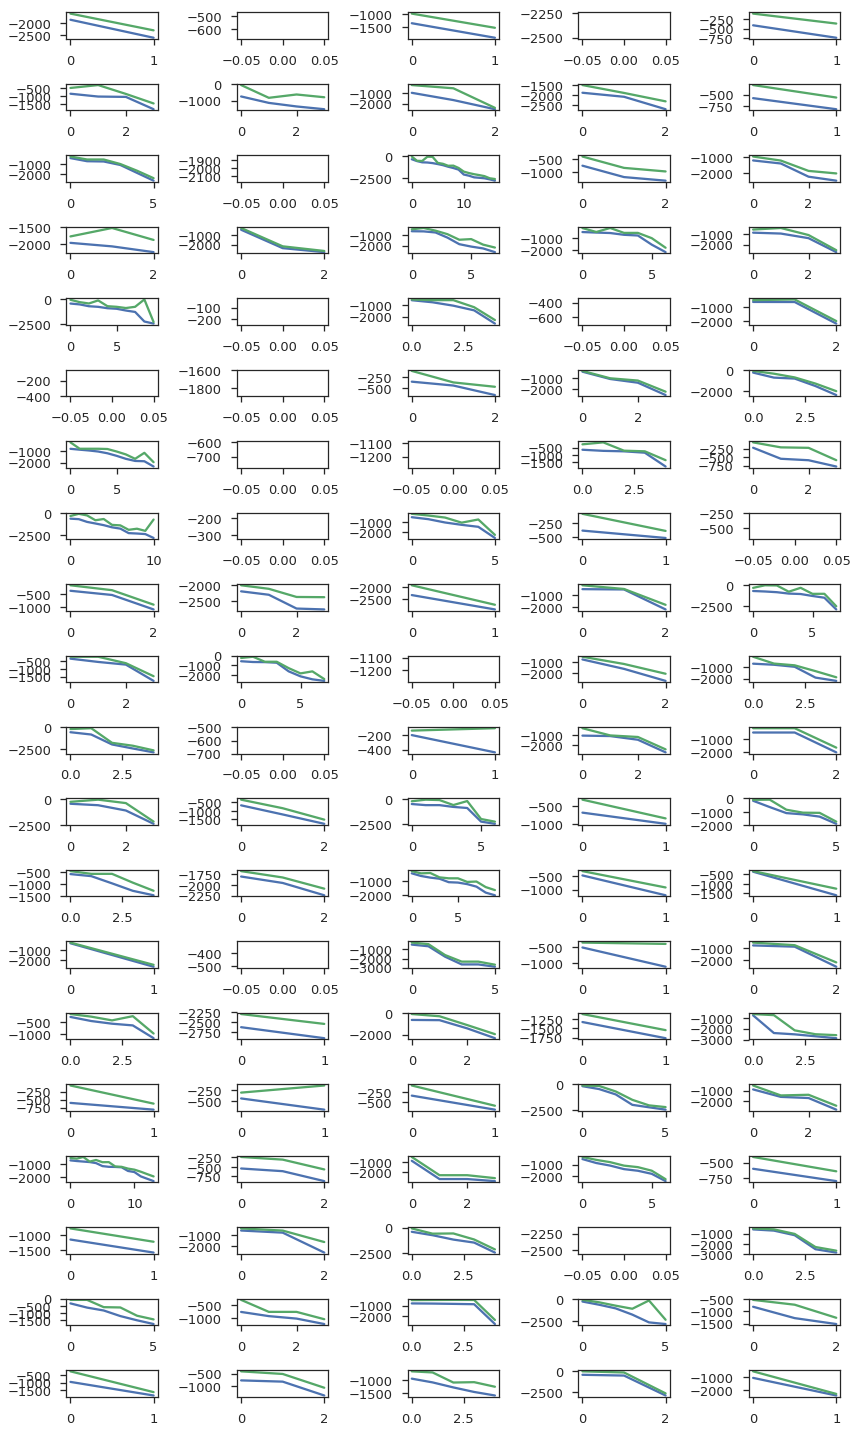

In [120]:
fig = plt.figure(figsize=(12, 20))


for i in range(1, 101):
    SK_ID_CURR = non_defaulters[i-1]
    ax = fig.add_subplot(20, 5, i)
    plot_prev_credit_durations(ax, x, SK_ID_CURR, 1)
    
plt.tight_layout();

In [136]:
# number of loans in last 6 months
last_6_months = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                             (prev_app.DAYS_DECISION >= -180)
                            ]

last_6_months = last_6_months.groupby('SK_ID_CURR').size()
last_6_months = app_train.SK_ID_CURR.map(last_6_months)

last_12_months = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                              (prev_app.DAYS_DECISION < -180) &\
                              (prev_app.DAYS_DECISION >= -365)
                            ]

last_12_months = last_12_months.groupby('SK_ID_CURR').size()
last_12_months = app_train.SK_ID_CURR.map(last_12_months)

last_18_months = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                              (prev_app.DAYS_DECISION < -365) &\
                              (prev_app.DAYS_DECISION >= -(540))
                            ]

last_18_months = last_18_months.groupby('SK_ID_CURR').size()
last_18_months = app_train.SK_ID_CURR.map(last_18_months)

In [140]:
x = app_train.loc[:, ['SK_ID_CURR', 'TARGET']]
x.loc[:, 'last_6_months']  = last_6_months
x.loc[:, 'last_12_months'] = last_12_months
x.loc[:, 'last_18_months'] = last_18_months

x.loc[:, 'ratio_6_12']     = last_6_months.divide(last_12_months, fill_value=np.nan)
x.loc[:, 'diff_6_12']      = last_12_months.subtract(last_6_months, fill_value=np.nan)

x.loc[:, 'ratio_12_18']     = last_12_months.divide(last_18_months, fill_value=np.nan)
x.loc[:, 'diff_12_18']      = last_18_months.subtract(last_12_months, fill_value=np.nan)

x.loc[:, 'payment_rate']    = app_train.AMT_ANNUITY / app_train.AMT_CREDIT

In [141]:
x.iloc[:, 1:].corr()

,TARGET,last_6_months,last_12_months,last_18_months,ratio_6_12,diff_6_12,ratio_12_18,diff_12_18,payment_rate
TARGET,1.000000,-0.009930,0.004733,0.000559,-0.019258,0.013447,0.004111,-0.003800,0.012704
last_6_months,-0.009930,1.000000,0.002285,0.028475,0.806779,-0.635615,-0.008824,0.024033,-0.024426
last_12_months,0.004733,0.002285,1.000000,-0.000202,-0.527738,0.770552,0.886734,-0.780762,-0.002268
last_18_months,0.000559,0.028475,-0.000202,1.000000,0.039616,-0.026934,-0.411480,0.624986,0.027827
ratio_6_12,-0.019258,0.806779,-0.527738,0.039616,1.000000,-0.921642,-0.470082,0.425884,-0.013078
diff_6_12,0.013447,-0.635615,0.770552,-0.026934,-0.921642,1.000000,0.690518,-0.612909,0.010362
ratio_12_18,0.004111,-0.008824,0.886734,-0.411480,-0.470082,0.690518,1.000000,-0.949321,-0.006832
diff_12_18,-0.003800,0.024033,-0.780762,0.624986,0.425884,-0.612909,-0.949321,1.000000,0.011452
payment_rate,0.012704,-0.024426,-0.002268,0.027827,-0.013078,0.010362,-0.006832,0.011452,1.000000


In [24]:
# number of times 365243.0 is there in DAYS_TERMINATION column for approved loans

num_termination_nulls = prev_app.loc[(prev_app.DAYS_TERMINATION == 365243.0) &\
                                     (prev_app.NAME_CONTRACT_STATUS == 'Approved')]\
                                .groupby('SK_ID_CURR').size()

num_termination_nulls = app_train.SK_ID_CURR.map(num_termination_nulls)
num_termination_nulls[num_termination_nulls.isnull()].shape[0] / len(num_termination_nulls)

0.5124271977262602

In [28]:
ss = pd.crosstab(num_termination_nulls, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

TARGET         0.0   1.0     ratio
SK_ID_CURR                        
1.0         101555  9138  0.082553
2.0          31854  2924  0.084076
3.0           3724   380  0.092593
4.0            307    49  0.137640
5.0              3     0  0.000000


### Differences between train and test set.

```
Experiment ideas

1. Look at the most recent status for bureau credit for train and test set.
    - We can find it using bureau balance table.
```

In [12]:
train_sample = app_train
test_sample  = app_test

In [13]:
# number of bureau credits for all of the customers in
# the train set.

train_bureau = train_sample.loc[:, ['SK_ID_CURR', 'TARGET']]\
                           .merge(bureau.loc[:, ['SK_ID_CURR',
                                  'SK_ID_BUREAU'
                                 ]], on='SK_ID_CURR', how='left')

train_bureau.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU
0,100002,1.0,6158904.0
1,100002,1.0,6158905.0
2,100002,1.0,6158906.0
3,100002,1.0,6158907.0
4,100002,1.0,6158908.0


In [14]:
test_bureau = test_sample.loc[:, ['SK_ID_CURR']]\
                           .merge(bureau.loc[:, ['SK_ID_CURR',
                                  'SK_ID_BUREAU'
                                 ]], on='SK_ID_CURR', how='left')

test_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU
0,100001,5896630.0
1,100001,5896631.0
2,100001,5896632.0
3,100001,5896633.0
4,100001,5896634.0


In [15]:
# for every bureau balance entry find the most recent status
most_recent_status = bureau_bal.groupby('SK_ID_BUREAU', as_index=False)['MONTHS_BALANCE'].max()
bureau_bal_recent  = bureau_bal.merge(most_recent_status, on=['SK_ID_BUREAU', 'MONTHS_BALANCE'], how='inner')

print(bureau_bal.shape[0], ' ', bureau_bal_recent.shape[0])

27299925   817395


In [16]:
# let's find out most recent credit of the bureau balance
train_bureau_bal = train_bureau.merge(bureau_bal_recent, on='SK_ID_BUREAU', how='left')

train_bureau_bal.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,100002,1.0,6158904.0,-15.0,C
1,100002,1.0,6158905.0,0.0,C
2,100002,1.0,6158906.0,-32.0,C
3,100002,1.0,6158907.0,-21.0,C
4,100002,1.0,6158908.0,-18.0,0


In [17]:
test_bureau_bal = test_bureau.merge(bureau_bal_recent, on='SK_ID_BUREAU', how='left')
test_bureau_bal.head()

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,100001,5896630.0,0.0,C
1,100001,5896631.0,0.0,C
2,100001,5896632.0,0.0,C
3,100001,5896633.0,0.0,C
4,100001,5896634.0,0.0,1


In [18]:
train_bureau_bal.STATUS.value_counts(dropna=False)

NaN    985830
C      278937
X      127153
0      111872
1        4106
5        1043
2         262
3          80
4          62
Name: STATUS, dtype: int64

In [19]:
test_bureau_bal.STATUS.value_counts(dropna=False)

C      138454
X       66692
0       43900
NaN      6688
1        1616
5         149
2          22
3           6
4           0
Name: STATUS, dtype: int64

** Most of the entries in the test sample have 0 or X as the most recent status reported by the Bureau for most of their credits. **

As a followup investigation let's look whether NaN in most recent status has any effect on target variable or not.

In [154]:
num_nulls_train = train_bureau_bal.STATUS.isnull().astype(np.uint8)
num_nulls_train = num_nulls_train.groupby(train_bureau_bal.SK_ID_CURR).sum()
total_size      = train_bureau_bal.groupby('SK_ID_CURR').size()

ratio_nulls     = num_nulls_train / total_size

ratio_nulls = train_sample.SK_ID_CURR.map(ratio_nulls)

y = train_bureau_bal.groupby('SK_ID_CURR')['TARGET'].mean()
y = train_sample.SK_ID_CURR.map(y)

In [155]:
pd.crosstab(ratio_nulls.values, y.values)

col_0,0.0,1.0
row_0,,
0.000000,84563,7465
0.016393,1,0
0.018182,0,1
0.031250,1,0
0.034483,1,0
0.038462,3,0
0.040000,0,1
0.043478,1,1
0.045455,0,2


In [91]:
7465 / 84563, 17315 / 197965

(0.08827737899554179, 0.08746495592655268)

We couldn't find any evidence that suggests that ratio of nulls has any predictive power.

```
Let's look at count distribution of most recent status and see if it has any predictive power.
```

In [21]:
# train_bureau_bal.loc[:, 'STATUS']  = train_bureau_bal.STATUS.cat.codes.astype(np.str)
train_bureau_bal.loc[:, 'STATUS']  = train_bureau_bal.STATUS.fillna('missing')

In [23]:
ss.columns

Index(['-1', '0', '1', '2', '3', '4', '5', '6', '7'], dtype='object', name='STATUS')

In [24]:
train_bureau_bal.STATUS.value_counts()

-1    985830
6     278937
7     127153
0     111872
1       4106
5       1043
2        262
3         80
4         62
Name: STATUS, dtype: int64

In [22]:
ss = train_bureau_bal.groupby(['SK_ID_CURR', 'STATUS']).size().unstack().fillna(0)
ss
# ss.loc[:, 'ratio_C_X'] = (ss['C'] + ss['X']) / ss['nan']

# tmp = train_sample.SK_ID_CURR.map(ss.ratio_C_X)
# tmp[tmp.isnull()].shape[0] / len(tmp)

STATUS,-1,0,1,2,3,4,5,6,7
SK_ID_CURR,,,,,,,,,
100002,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
100003,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100006,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100008,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100009,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
100011,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


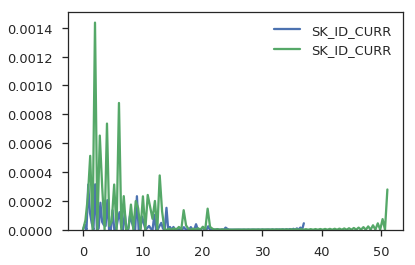

In [158]:
sns.kdeplot(tmp[train_sample.TARGET == 0])
sns.kdeplot(tmp[train_sample.TARGET == 1]);

In [159]:
tmp[train_sample.TARGET == 1].value_counts(dropna=False, normalize=True).iloc[:10]

 0.000000     0.697603
 inf          0.273152
NaN           0.027553
 2.000000     0.000242
 3.000000     0.000201
 6.000000     0.000161
 4.000000     0.000161
 1.000000     0.000121
 13.000000    0.000121
 11.000000    0.000081
Name: SK_ID_CURR, dtype: float64

In [160]:
tmp[train_sample.TARGET == 0].value_counts(dropna=False, normalize=True).iloc[:10]

 0.000000    0.700339
 inf         0.278242
NaN          0.020900
 1.000000    0.000067
 2.000000    0.000050
 3.000000    0.000042
 4.000000    0.000042
 9.000000    0.000035
 6.000000    0.000035
 8.000000    0.000028
Name: SK_ID_CURR, dtype: float64

In [11]:
bureau_bal.STATUS.value_counts(dropna=False)

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [10]:
bureau_bal.STATUS.cat.codes.value_counts(dropna=False)

6    13646993
0     7499507
7     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
dtype: int64